In [1]:
import pandas as pd
import os
import numpy as np
from scipy.stats import mannwhitneyu
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.cbook import boxplot_stats
import re
from scipy.stats import mannwhitneyu
import warnings
warnings.filterwarnings('ignore') #supresses warnings for now
#warnings.filterwarnings(action='once') #shows warnings once
from statannotations.Annotator import Annotator


dataFilePath = os.path.join(os.getcwd(),'Data')

kicsSVdf = pd.read_csv(os.path.join(dataFilePath,'kics_structural_variations.txt'), sep = '\t', header = 0)
#kicsTEdf = pd.read_csv(os.path.join(dataFilePath,'kics_transposable_elements.txt'), sep = '\t', header = 0)
lfsSVdf = pd.read_csv(os.path.join(dataFilePath,'lfs_structural_variations.txt'), sep = '\t', header = 0)
#lfsTEdf = pd.read_csv(os.path.join(dataFilePath,'lfs_transposable_elements.txt'), sep = '\t', header = 0)
lfsClinicdf = pd.read_csv(os.path.join(dataFilePath,'lfs_clinical_main.tsv'), sep = '\t', header = 0)
kicsClinicdf = pd.read_csv(os.path.join(dataFilePath,'kics_clinical_edited.csv'), encoding='latin-1')

In [2]:
"""
SV clean up
"""
def maxGDAFFilter(colName: str, df: pd.DataFrame)->pd.DataFrame:
    temp = df[colName].str.contains(pat=',')
    Index = list(np.where(temp == True)[0])
    temp = df[colName].iloc[Index]
    tempIndex = temp.index 
    
    for i in tempIndex:
        tempList = temp[i].split(',')
        tempList = [float(a) for a in tempList]
        maxTemp = max(tempList)
        df[colName][i] = maxTemp

    df[colName] = df[colName].astype('float64')
    
    return df
    
kicsSVdf = maxGDAFFilter('GD_AF', kicsSVdf)
lfsSVdf = maxGDAFFilter('GD_AF', lfsSVdf)

listValSearch = ['291775', '298313', '315666', '320118', '18_1907']
# searched for kID of 63, 83, 156, 171, 219
# kID 120 141 and 232 do not have any matches...
#what would make this that much better is if it was a dict. Computationally less heavy?

for i in listValSearch: 
    kicsSVdf.drop(kicsSVdf[kicsSVdf['sample_id'].str.contains(i)==True].index, inplace = True)

In [3]:
"""
full filter and rare
"""

kicsSVdf = kicsSVdf.loc[(kicsSVdf['AnnotSV type'] == 'full') & (kicsSVdf['GD_AF'] < 0.01)]
lfsSVdf = lfsSVdf.loc[(lfsSVdf['AnnotSV type'] == 'full') & (lfsSVdf['GD_AF'] < 0.01)]

kicsSVdf['SV chrom'] = kicsSVdf['SV chrom'].astype(str)
lfsSVdf['SV chrom'] = lfsSVdf['SV chrom'].astype(str)

kicsSVdf['sample_id'] = kicsSVdf['sample_id'].astype(str)
lfsSVdf['sample_id'] = lfsSVdf['sample_id'].astype(str)

kicsSVdf['sample_id'] = kicsSVdf['sample_id'].str.replace(" ", "")
lfsSVdf['sample_id'] = lfsSVdf['sample_id'].str.replace(" ", "")

#kicsSVnum = kicsSVF['sample_id'].count()
#lfsSVnum = lfsSVF['sample_id'].count()


In [4]:
"""
Kics clinic df cleaning
"""
#listValSearch = ['291775', '298313', '315666', '320118', '18_1907']
listValSearch = ['63', '83', '156', '171', '219', '120', '141', '232']
# searched for kID of 63, 83, 156, 171, 219
# kID 120 141 and 232 do not have any matches...

kicsClinicdf['KiCS ID'] = kicsClinicdf['KiCS ID'].astype(str)
kicsClinicdf['KiCS ID'] = kicsClinicdf['KiCS ID'].str.replace(" ", "")

for i in listValSearch:
    kicsClinicdf.drop(kicsClinicdf[kicsClinicdf['KiCS ID']==i].index, inplace = True)

#these two lines are causing us to go from 140->90 ish samples    
kicsClinicdf.drop(kicsClinicdf.loc[kicsClinicdf['tissue_type']=='?'].index, inplace=True)
kicsClinicdf.drop(kicsClinicdf.loc[pd.isna(kicsClinicdf['lfs_cancer_type_diagnosis'])].index, inplace=True)


# # intial tissue types and diagnosis types
# kUniqueTissue = kicsClinicdf['tissue_type'].unique()
# kUniqueDiag = kicsClinicdf['lfs_cancer_type_diagnosis'].unique()

# print(kUniqueTissue)
# print(kUniqueDiag)

In [5]:
"""
lfs clinic df cleaning
"""
lfsClinicdf['sample'] = lfsClinicdf['sample'].astype(str)
lfsClinicdf['sample'] = lfsClinicdf['sample'].str.replace(" ", "")

for i in listValSearch:
    lfsClinicdf.drop(lfsClinicdf[lfsClinicdf['sample']==i].index, inplace = True)
    

#print(lfsClinicdf[lfsClinicdf['tissue_type']=='CNS']) #more than 1 patient
    
lfsClinicdf.drop(lfsClinicdf.loc[lfsClinicdf['tissue_type']=='?'].index, inplace=True)
lfsClinicdf.drop(lfsClinicdf.loc[pd.isna(lfsClinicdf['cancer_diagnosis'])].index, inplace=True)


#print(lfsClinicdf[lfsClinicdf['tissue_type']=='CNS']) #more than 1 patient

# lUniqueTissue = lfsClinicdf['tissue_type'].unique()
# lUniqueDiag = lfsClinicdf['cancer_diagnosis'].unique()

# print(lUniqueTissue)
# print(lUniqueDiag)

In [6]:
# def calcFliers(df, xCol, yCol, lfs, kics):
#     for i in list(df[xCol].unique()):
#         tempdf = df.loc[df[xCol]==i]
#         dic = boxplot_stats(tempdf[yCol])
#         print(dic)

In [88]:
"""
Outliers find go
"""
def findOutliers(df, std,yCol):
    #return a list of sample_id that are outliers
    #give me somethig that is for one box in the box plot
    q1 = df.quantile(0.25).values[0]
    q3 = df.quantile(0.75).values[0]
    
    IQR = q3-q1
    
    upperBound = (q1-std*IQR)
    lowerBound = (q3+std*IQR)
    
    outliers = df.loc[(df[yCol]< upperBound) | (df[yCol]>lowerBound)]
    print(outliers)
    return list(outliers['sample_id'].unique())
    
    
def outliersInDf(df, xCol,yCol, std = 1.5):
    #unique list 
    uniqueList = list(df[xCol].unique())
    #get all types of boxes the stuff on the x axis categories
    for i in uniqueList:
        tempdf = df[df[xCol]==i]
        list_ids = findOutliers(tempdf,std,yCol)
        print("the outliers for "+i+" are:")
        print(list_ids)
        print()


In [89]:
def BoxGraphMulti(df: pd.DataFrame, xCol, yCol, compCol, orderList):
    #print(df)
    
    plt.rcParams["figure.figsize"] = [15, 10]
    ax = sns.boxplot(data=df, x=xCol, y=yCol, hue=compCol, medianprops={"linewidth": 4, 'color':'black'})
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha="right")

    
    lfs = df[df[compCol]=='lfs']
    kics = df[df[compCol]=='kics']
    print('LFS')
    outliersInDf(lfs, xCol,yCol)
    print('KICS')
    outliersInDf(kics, xCol,yCol)
    
    excludeList = list(set(lfs[xCol]).symmetric_difference(set(kics[xCol])))

    #add statistical test here
    listPairing = []
    #pairings for multi correction
    for i in orderList:
        #excludeList = ['Unaffeceted', 'Sarcoma', 'Other', 'US', 'Thyroid', 'Ovaries']        
        #tissueDiff = list(set(df['tissue_type']).symmetric_difference(set(df['tissue_type'])))
        #diagDiff = list(set(df['cancer_diagnosis']).symmetric_difference(set(df['lfs_cancer_type_diagnosis'])))
        
        if i not in excludeList:
            p1 = (i, 'kics')
            p2 = (i, 'lfs')
            p = (p1,p2)
            listPairing.append(p)
    if xCol == 'age6':
        p1 = ('>=6','kics')
        p2 = ('<6','kics')
        p = (p1,p2)
        listPairing.append(p)
        p1 = ('>=6','lfs')
        p2 = ('<6','lfs')
        p = (p1,p2)
        listPairing.append(p)
        p1 = ('>=6','lfs')
        p2 = ('Unaffected','lfs')
        p = (p1,p2)
        listPairing.append(p)
        p1 = ('Unaffected','lfs')
        p2 = ('<6','lfs')
        p = (p1,p2)
        listPairing.append(p)
        
        
    annot = Annotator(ax, listPairing, data=df, x=xCol, y=yCol, hue=compCol)
    annot.configure(test='Mann-Whitney',
                    text_format='star', loc='outside', verbose=2)
    annot.apply_and_annotate()
    
    
    #calculating outliers
    
#     calcFliers(df, xCol, yCol, lfs, kics)

    plt.show()

In [90]:
def BarGraphNormalized(label1: str, label2:str, df: pd.DataFrame, col1: str, col2: str,
                        xTitle: str, yTitle: str, divisor1: float, divisor2: float,
                        labels: list):
    #'kics', 'lfs', invdf, 'kchrom', 'lchrom', 'Chromosomes','Frequency','Graph2-INV',kicsSVnum, lfsSVnum

    title = label1 + " " + label2
    count1 = df[col1].value_counts()
    count2 = df[col2].value_counts()
    
    x_axis = np.arange(len(labels))
        
    for i in labels:
        if (not(i in count1)):
            add = pd.Series([0], index=[i])
            count1 = count1.append(add)
        if (not(i in count2)):
            add = pd.Series([0], index=[i])
            count2 = count2.append(add)
            
    plt.bar(x_axis - 0.2, [count1[a]/divisor1 for a in labels], 0.4, label = label1)
    plt.bar(x_axis + 0.2, [count2[a]/divisor2 for a in labels], 0.4, label = label2)

    #plt.tick_params(labelrotation=45, labelright=True)
    #plt.setp(ha="right", rotation=45)
    
    plt.xticks(x_axis, labels, ha='right', rotation = 45)
    plt.xlabel(xTitle)
    plt.ylabel(yTitle)
    plt.title(title)
    plt.legend()
    plt.show()


In [91]:
"""
kics matching between SV and Clinical
"""

def kIdAbbv(clinicDf, svDf, clinicCol, svCol):
    
    clinicDf.drop(clinicDf[clinicDf[clinicCol]=='Not applicable'].index, inplace = True)
    
    svDf[svCol] = svDf[svCol].astype(str)
    clinicDf[clinicCol] = clinicDf[clinicCol].astype(str)
    svDf[svCol] =  svDf[svCol].str.replace(" ", "")
    clinicDf[clinicCol] = clinicDf[clinicCol].str.replace(" ", "")
    
    list1 = svDf[svCol].unique()
    list2 = clinicDf[clinicCol].unique()
    
    svDict = dict()
    clinicDict = dict()
    
    for i in range (len(list1)):
        tempList = re.findall('\d{3,}', list1[i])

        #if empty, take the second one
        if not tempList:
            tempList = re.findall('\d+', list1[i])
            svDict[list1[i]] = tempList[1]

        #if not empty 
        else:
            svDict[list1[i]] = tempList[0]


    for i in range (len(list2)):    
        tempList = re.findall('\d{3,}', list2[i])
    
        #if empty, take the second one
        if not tempList:
            tempList = re.findall('\d+', list2[i])
            clinicDict[list2[i]] = tempList[1]

        #if not empty 
        else:
            clinicDict[list2[i]] = tempList[0]
    

    clinicDf['abbv_id'] = clinicDf[clinicCol].map(clinicDict)
    svDf['abbv_id'] = svDf[svCol].map(svDict)
    
    print(len(svDf[svCol].unique()))
#     print(svDf[svCol].unique())
    
    df = pd.merge(svDf[[svCol,'SV type','abbv_id']],                   
                     clinicDf,
                     left_on = 'abbv_id', 
                     right_on = 'abbv_id', 
                     how='inner')
    return df

##clinicCol, 'tumour_class','tissue_type','lfs_cancer_type_diagnosis', 'abbv_id','diagnosis_age (days)']
##

In [92]:
UberbigKDf = kIdAbbv(kicsClinicdf, kicsSVdf, 'CCP germline', 'sample_id')
bigKDf = UberbigKDf[['sample_id','tumour_class','tissue_type','lfs_cancer_type_diagnosis',
                     'abbv_id','diagnosis_age (days)','CCP germline','SV type']]
bigKDf=bigKDf.rename(columns={'diagnosis_age (days)': 'ageofonset'})
print(len(bigKDf['abbv_id'].unique()))
# print(bigKDf['sample_id'].unique())
# print(len(kicsSVdf['sample_id'].unique()))
# print(len(kicsClinicdf['CCP germline'].unique()))
#prints out how many we had before the id matching and how many we have left after the id matching

191
93


In [93]:
print(bigKDf)
print(UberbigKDf)

      sample_id       tumour_class tissue_type lfs_cancer_type_diagnosis  \
0        313703         CNS TUMORS         CNS                    Glioma   
1        313703         CNS TUMORS         CNS                    Glioma   
2        313703         CNS TUMORS         CNS                    Glioma   
3        313703         CNS TUMORS         CNS                    Glioma   
4        313703         CNS TUMORS         CNS                    Glioma   
...         ...                ...         ...                       ...   
16734    292600  LEUKEMIA/LYMPHOMA       Blood                     B-ALL   
16735    292600  LEUKEMIA/LYMPHOMA       Blood                     B-ALL   
16736    292600  LEUKEMIA/LYMPHOMA       Blood                     B-ALL   
16737    292600  LEUKEMIA/LYMPHOMA       Blood                     B-ALL   
16738    292600  LEUKEMIA/LYMPHOMA       Blood                     B-ALL   

      abbv_id ageofonset CCP germline SV type  
0      313703       1952       313703  

In [94]:
"""Filter the ? and the nan"""
#print(bigKDf['tissue_type'].unique())
bigKDf.drop(bigKDf.loc[bigKDf['tissue_type']=='?'].index, inplace=True)

#bigKDfDiag.drop(bigKDf.loc[pd.isna(bigKDf['lfs_cancer_type_diagnosis'])].index, inplace=True)
print(len(bigKDf['abbv_id'].unique()))
#print(kicsClinicdf['tissue_type'].value_counts())

93


In [95]:
lfsSVdf['sample_id'] = lfsSVdf['sample_id'].astype(str)
lfsClinicdf['sample'] = lfsClinicdf['sample'].astype(str)

In [96]:
print(len(lfsSVdf['sample_id'].unique())) #only 65 to begin with D:
print(lfsSVdf['sample_id'].unique())

print(len(lfsClinicdf['sample'].unique()))

65
['4257' 'SJACT008_G' '808' '2085' '1087' '1092' '3805' '3136A' '4033'
 '2447' '353' '3806' '4854' '1478' '2262' '4028' '2957' '3688' '93' '1357'
 '2565' '4329' '4535_S1' '3298A' '2349' '2446' '3473' '5567' '3273' '3885'
 '3432' '1843' '3763' '3503' 'PD13489b' '2463' '2760A' '3643' 'SJACT001_G'
 '4227' '5537' '3367' 'SJACT002_G' '2815' '5536' '3634' '1476'
 'SJACT005_G' '3425' '3365' '2413' 'SJACT007_G' '3356' '3361' '3687_2'
 '3332' '94' '1355' '2784' '2465' '3319' 'PD7195b' '3334' '352' '2765']
460


In [97]:
"""
Can directly map the two
Apply on Filtered Prelim Graphs
"""
UberbigLDf = pd.merge(lfsSVdf[['sample_id','SV chrom','GD_AF', 'SV type']],
                 lfsClinicdf,
                 left_on = 'sample_id',
                 right_on = 'sample',
                 how='inner')
bigLDf = UberbigLDf[['sample_id','SV chrom','GD_AF', 'SV type','sample',
                     'tissue_type','cancer_diagnosis','ageofonset']]

print(bigLDf)
print(UberbigLDf)

     sample_id SV chrom     GD_AF SV type sample tissue_type cancer_diagnosis  \
0         4257        1  0.000047     DEL   4257      Breast           Breast   
1         4257        1  0.000338     DEL   4257      Breast           Breast   
2         4257        1  0.002795     DEL   4257      Breast           Breast   
3         4257        1  0.005914     DEL   4257      Breast           Breast   
4         4257        1 -1.000000     DEL   4257      Breast           Breast   
...        ...      ...       ...     ...    ...         ...              ...   
8381      2765        9 -1.000000     DEL   2765     Adrenal              ACC   
8382      2765        X -1.000000     DEL   2765     Adrenal              ACC   
8383      2765        X -1.000000     INV   2765     Adrenal              ACC   
8384      2765        X  0.009091     DEL   2765     Adrenal              ACC   
8385      2765        Y -1.000000     DEL   2765     Adrenal              ACC   

      ageofonset  
0       

In [98]:
"""
Difference between the unique tissues and unique diagnosis in kics vs lfs
"""

tissueDiff = list(set(bigLDf['tissue_type']).symmetric_difference(set(bigKDf['tissue_type'])))
diagDiff = list(set(bigLDf['cancer_diagnosis']).symmetric_difference(set(bigKDf['lfs_cancer_type_diagnosis'])))

print(tissueDiff)
print(diagDiff)

['Unaffected', 'Thyroid', 'Ovaries', 'Other']
['B-ALL', 'AMKL', 'T-LL', 'CSA', 'MFS', 'Meningioma', 'AA', 'MPAL', 'High Grade Sarcoma', 'PNET', 'Ovaries', 'AL', 'Other', 'MFH', 'Thyroid', 'AML', 'Undifferentiated sarcoma', 'CPC', 'US', 'LMS', 'T-NHL', 'ALL', 'Unaffected']


In [99]:
"""
Drop the rows that are in the diff
"""

####YOU DROPPED TOO MANY, Don't drop any
#bigLDf.drop(bigLDf[bigLDf['tissue_type'].isin(tissueDiff)].index, inplace = True)
#bigKDf.drop(bigKDf[bigKDf['tissue_type'].isin(tissueDiff)].index, inplace = True)

#bigLDf.drop(bigLDf[bigLDf['cancer_diagnosis'].isin(diagDiff)].index, inplace = True)
#bigKDf.drop(bigKDf[bigKDf['lfs_cancer_type_diagnosis'].isin(diagDiff)].index, inplace = True)

kicsTissue = pd.DataFrame(data = {'tissue_type':bigKDf['tissue_type'], 'id':bigKDf['sample_id']})
kicsT = kicsTissue

lfsTissue = pd.DataFrame(data = {'tissue_type':bigLDf['tissue_type'], 'id':bigLDf['sample']})
lfsT = lfsTissue

groupedTissue = pd.DataFrame(data={'ktissue':kicsTissue['tissue_type'], 'ltissue':lfsTissue['tissue_type']})

lfsDiag = pd.DataFrame(data = {'diag':bigLDf['cancer_diagnosis'], 'id':bigLDf['sample']})
# lfsD = lfsDiag
kicsDiag = pd.DataFrame(data = {'diag':bigKDf['lfs_cancer_type_diagnosis'], 'id':bigKDf['sample_id']})
kicsD = kicsDiag

groupedDiag = pd.DataFrame(data={'kdiag':kicsDiag['diag'],'ldiag': lfsDiag['diag']})

kicsTidList = kicsDiag['id'].unique()
lfsTidList = lfsDiag['id'].unique()
kicsDiagList = list(kicsDiag['diag'].unique())
lfsDiagList = list(lfsDiag['diag'].unique())

kicsIdList = kicsTissue['id'].unique()
kicsTissueList = list(kicsTissue['tissue_type'].unique())
lfsTissueList = list(lfsTissue['tissue_type'].unique())
lfsIdList = lfsTissue['id'].unique()

#print(type(kicsTissueList))

uniqueTissue = list(set(kicsTissueList+lfsTissueList))
uniqueDiag = list(set(kicsDiagList+lfsDiagList))

print(uniqueTissue)
print(uniqueDiag)
#print(kicsTissue['tissue_type'].unique())
#print(lfsTissue['tissue_type'].unique())


['Bone', 'Unaffected', 'Blood', 'US', 'CNS', 'Colon', 'Breast', 'Adrenal', 'Thyroid', 'Ovaries', 'Soft Tissue', 'Other']
['T-LL', 'MFS', 'Meningioma', 'AA', 'RMS', 'MPAL', 'PNET', 'AL', 'ACC', 'Other', 'MFH', 'AML', 'LMS', 'Breast', 'T-NHL', 'ALL', 'Unaffected', 'B-ALL', 'AMKL', 'CSA', 'OS', 'Colon', 'High Grade Sarcoma', 'Ovaries', 'Glioma', 'Undifferentiated sarcoma', 'US', 'CPC', 'Thyroid']


# Diagnosis Type

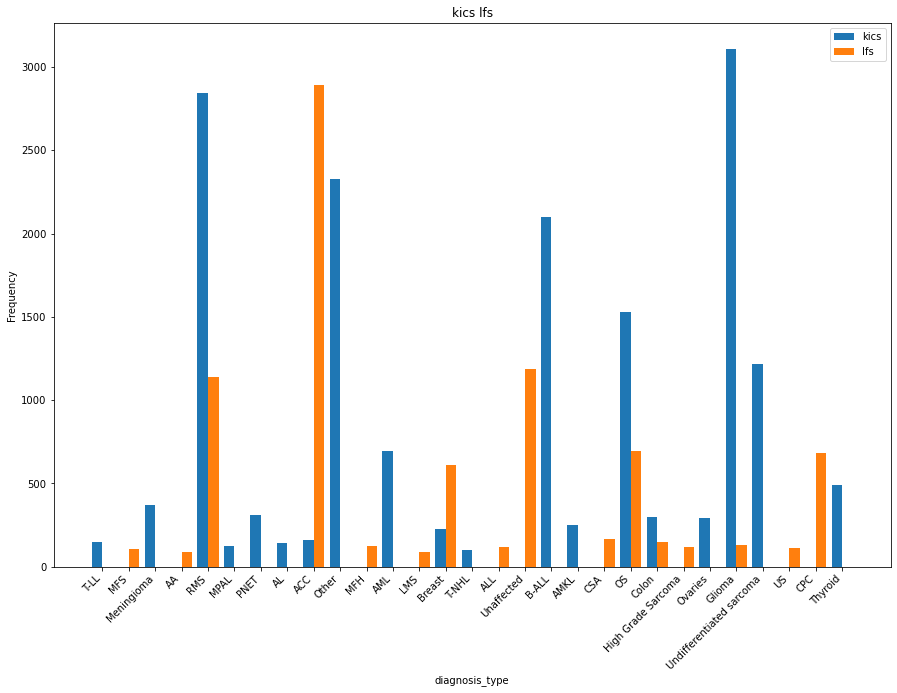

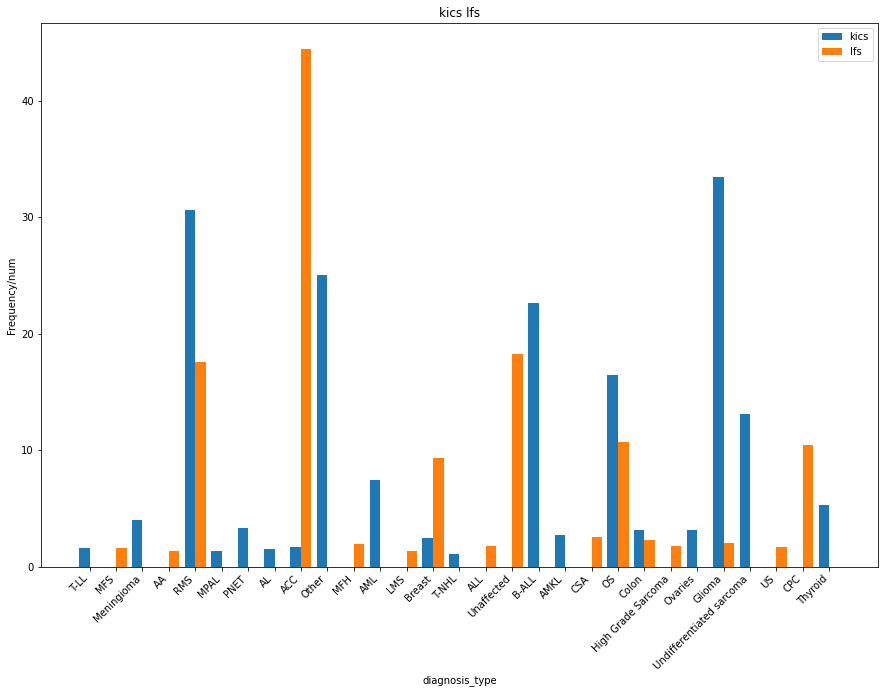

In [100]:
BarGraphNormalized('kics', 'lfs', groupedDiag, 'kdiag', 'ldiag', 'diagnosis_type', 'Frequency', 1.0,1.0, uniqueDiag)
    
BarGraphNormalized('kics', 'lfs', groupedDiag, 'kdiag', 'ldiag', 'diagnosis_type','Frequency/num',
                   len(kicsTidList), len(lfsTidList), uniqueDiag)

# Tissue Type

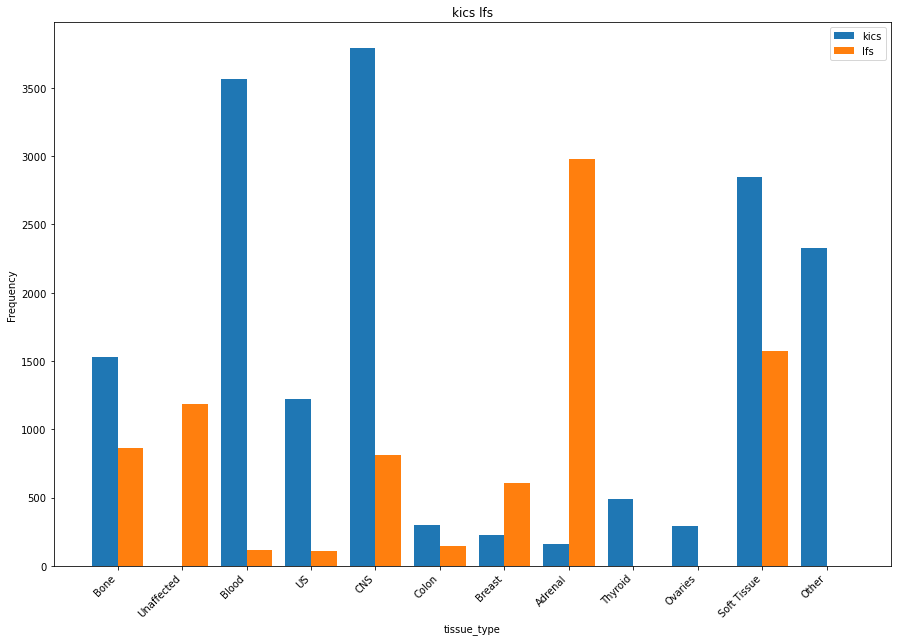

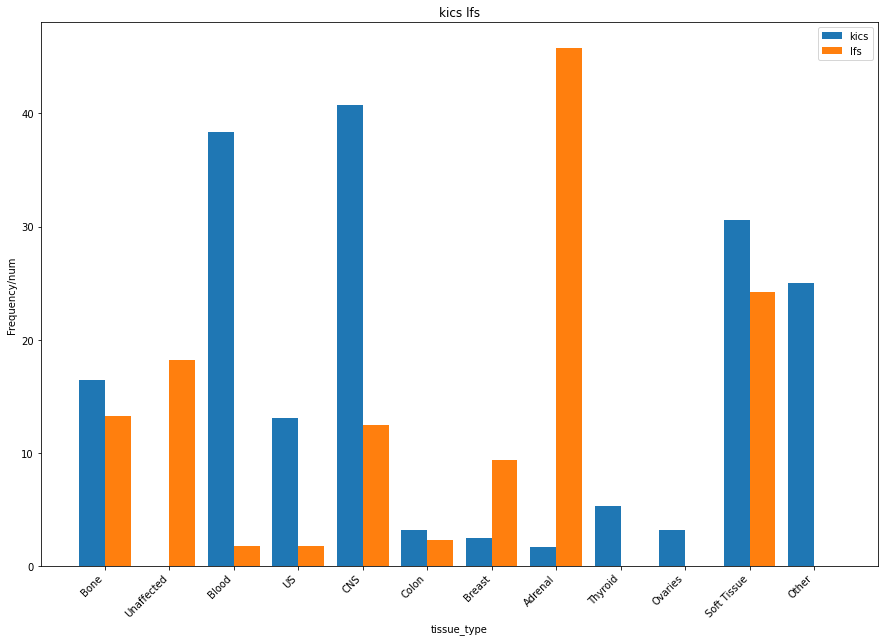

In [101]:
BarGraphNormalized('kics', 'lfs', groupedTissue, 'ktissue', 'ltissue', 'tissue_type','Frequency',
                   1.0,1.0, uniqueTissue)

BarGraphNormalized('kics', 'lfs', groupedTissue, 'ktissue', 'ltissue', 'tissue_type', 'Frequency/num',
                  len(kicsIdList), len(lfsIdList), uniqueTissue)

In [102]:
bigKDf.rename(columns = {'lfs_cancer_type_diagnosis':'cancer_diagnosis'}, inplace = True)

kDel = bigKDf.loc[bigKDf['SV type'] == 'DEL']
kDup = bigKDf.loc[bigKDf['SV type'] == 'DUP']
kInv = bigKDf.loc[bigKDf['SV type'] == 'INV']

lDel = bigLDf.loc[bigLDf['SV type'] == 'DEL']
lDup = bigLDf.loc[bigLDf['SV type'] == 'DUP']
lInv = bigLDf.loc[bigLDf['SV type'] == 'INV']

print(kDel.head(30))
print(lDel.head(30))

   sample_id tumour_class tissue_type cancer_diagnosis abbv_id ageofonset  \
0     313703   CNS TUMORS         CNS           Glioma  313703       1952   
1     313703   CNS TUMORS         CNS           Glioma  313703       1952   
3     313703   CNS TUMORS         CNS           Glioma  313703       1952   
4     313703   CNS TUMORS         CNS           Glioma  313703       1952   
5     313703   CNS TUMORS         CNS           Glioma  313703       1952   
6     313703   CNS TUMORS         CNS           Glioma  313703       1952   
7     313703   CNS TUMORS         CNS           Glioma  313703       1952   
8     313703   CNS TUMORS         CNS           Glioma  313703       1952   
9     313703   CNS TUMORS         CNS           Glioma  313703       1952   
10    313703   CNS TUMORS         CNS           Glioma  313703       1952   
11    313703   CNS TUMORS         CNS           Glioma  313703       1952   
12    313703   CNS TUMORS         CNS           Glioma  313703       1952   

In [103]:
def filterBig(df, xcol):
    uniquelist = list(df[xcol].unique())
    n=5
    sampleIdCol = df.columns
    sampleIdCol = sampleIdCol[0]
    
    #if there is less than 5 (<5) unique ids then add to remove list
    removelist = []
    for i in uniquelist:
        dog = df.loc[df[xcol]==i]
        num = dog[sampleIdCol].nunique()        
        if num < n:
            removelist.append(i)
                
    df = df[~df[xcol].isin(removelist)]
        
    return df

In [104]:
def graphSVTissue(kdf, ldf, uniqueList, isTissue):
    if isTissue:
        var = 'tissue_type'

    else:
        var = 'cancer_diagnosis'
    
    kdf = kdf.drop(['abbv_id', 'SV type','ageofonset'], axis=1)
    kdf = kdf.groupby(['sample_id']).value_counts()
    kdf = kdf.to_frame().reset_index()
    kdf.rename(columns = {0:'freq'}, inplace = True)
    
    kdf = filterBig(kdf,var)
    #print(kdf)
    #kdf = pd.melt(kdf, id_vars=[var], value_vars=['freq'])
    #print(kdf)
    kdf['dataset'] = 'kics'

    ldf = ldf.drop(['SV chrom', 'GD_AF',
                        'SV type','ageofonset'], axis=1)
    ldf = ldf.groupby(['sample_id']).value_counts()
    ldf = ldf.to_frame().reset_index()
    ldf.rename(columns = {0:'freq'}, inplace = True)

    ldf = filterBig(ldf,var)
    
    #ldf = pd.melt(ldf, id_vars=[var], value_vars=['freq'])
    ldf['dataset'] = 'lfs'

    mergedDf = pd.concat([ldf, kdf])
    #print(mergedDf.head(50))
    
    #excluding all that don't have a pair         
    excludeList = list(set(ldf[var]).symmetric_difference(set(kdf[var])))
    mergedDf = mergedDf[~mergedDf[var].isin(excludeList)]
        
    uniqueList = list(mergedDf[var].unique())
    #print(mergedDf)
    
    BoxGraphMulti(mergedDf, var, 'freq', 'dataset', uniqueList) 

LFS
  sample_id cancer_diagnosis  freq dataset
9      2349              RMS    73     lfs
the outliers for RMS are:
['2349']

   sample_id cancer_diagnosis  freq dataset
58  PD13489b               OS   242     lfs
the outliers for OS are:
['PD13489b']

KICS
   sample_id cancer_diagnosis  freq dataset
14    284386              RMS   532    kics
the outliers for RMS are:
['284386']

  sample_id cancer_diagnosis  freq dataset
7    271112               OS   417    kics
the outliers for OS are:
['271112']

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

OS_lfs vs. OS_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:7.895e-01 U_stat=2.000e+01
RMS_lfs vs. RMS_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:1.225e-02 U_stat=2.050e+01


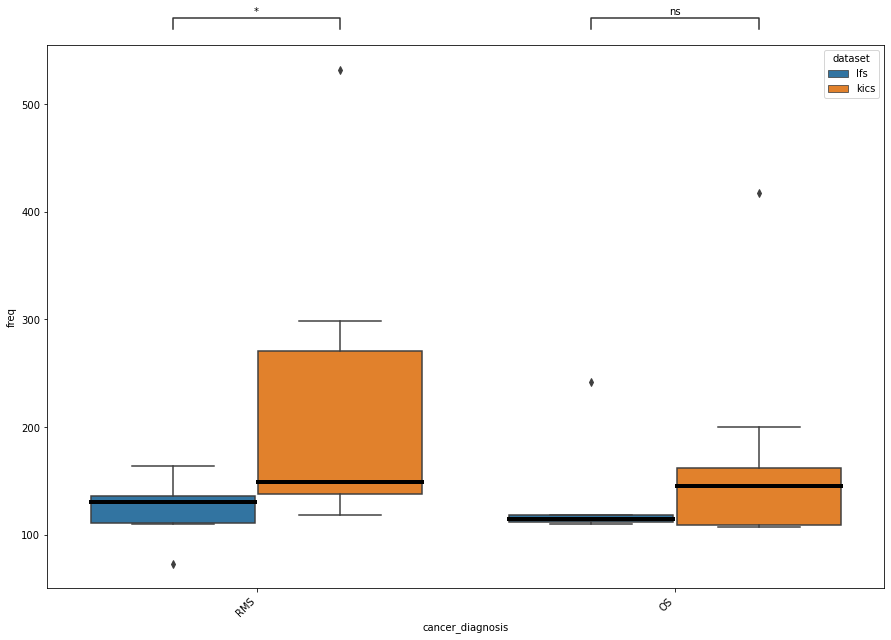

LFS
   sample_id  tissue_type  freq dataset
9       2349  Soft Tissue    73     lfs
41      3763  Soft Tissue   164     lfs
the outliers for Soft Tissue are:
['2349', '3763']

   sample_id tissue_type  freq dataset
27      3356         CNS   322     lfs
the outliers for CNS are:
['3356']

   sample_id tissue_type  freq dataset
58  PD13489b        Bone   242     lfs
the outliers for Bone are:
['PD13489b']

KICS
   sample_id tissue_type  freq dataset
9     271116         CNS   369    kics
16    286909         CNS   484    kics
36    300683         CNS   472    kics
the outliers for CNS are:
['271116', '286909', '300683']

   sample_id  tissue_type  freq dataset
14    284386  Soft Tissue   532    kics
the outliers for Soft Tissue are:
['284386']

  sample_id tissue_type  freq dataset
7    271112        Bone   417    kics
the outliers for Bone are:
['271112']

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 

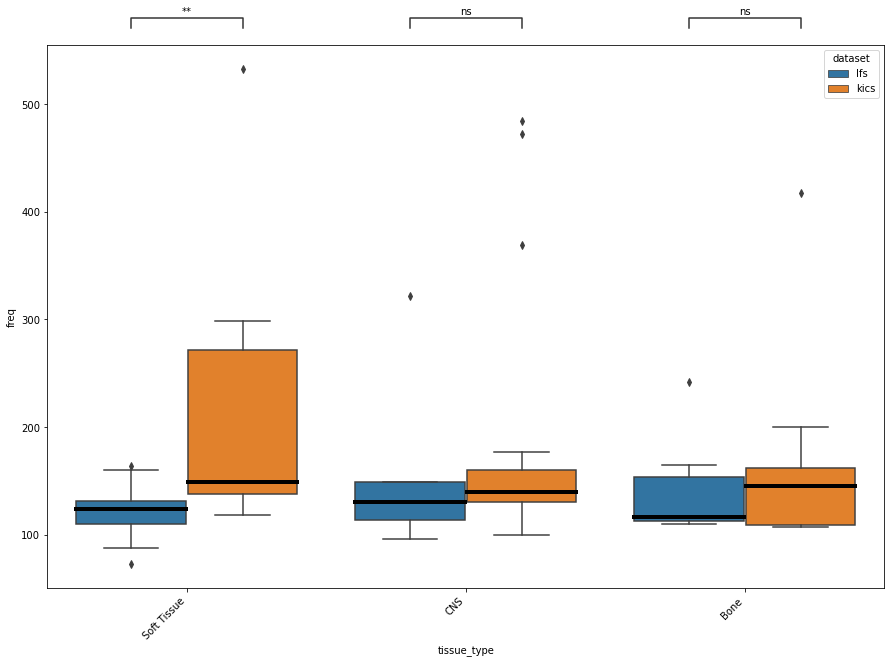

In [105]:
kicsTissue = bigKDf.drop(['CCP germline', 'tumour_class', 'cancer_diagnosis'], axis=1)
kicsDiag = bigKDf.drop(['CCP germline', 'tumour_class', 'tissue_type'], axis=1)

lfsTissue = bigLDf.drop(['cancer_diagnosis', 'sample'],axis=1)
lfsDiag = bigLDf.drop(['tissue_type', 'sample'],axis=1)

graphSVTissue(kicsDiag, lfsDiag, uniqueDiag, False)

#print(lfsTissue)
graphSVTissue(kicsTissue, lfsTissue, uniqueTissue,True)

# RMS and Soft Tissue Breakdown

In [106]:
#DEL, DUP, INV specific Soft Tissue and RMS

kDf = UberbigKDf[['sample_id', 'SV type', 'abbv_id', 'KiCS ID', 'ICDO-diagnosis',
       'tissue_type', 'lfs_cancer_type_diagnosis','Previous cancers', 'Germline Sample from',
       'Germline sample type', 'CCP germline.1', 'WGS DNA germline',
       'WGS germline', 'pathology_id', 'Sample type', 'CCP tumor', 'CCP PPID',
       'CCP', 'WGS tumor ID', 'WGS Tumor', 'RNA ID', 'RNA',
       'single_somatic_specimen', 'disease_state', 'sample_type',
       'post_treatment', 'sample site', 'tumour_class', 'Sex',
       'diagnosis_age (days)', 'no_chemo_or_xrt']]

#use ICDO-diagnosis

lDf = UberbigLDf[['sample_id', 'SV chrom', 'GD_AF', 'SV type', 'sample',
       'tm_donor', 'tissue_type', 'cancer_diagnosis', 'active_cancer',
       'gender', 'systemic_treatment_atdraw', 'ageofonset', 'agesamplecollection',
       'cancer_num', 'cancer1_age_diff', 'cancer1', 'cancer1_ageofonset',
       'cancer2', 'cancer2_ageofonset', 'cancer3', 'cancer3_ageofonset',
       'cancer4', 'cancer4_ageofonset', 'cancer5', 'cancer5_ageofonset',
       'cancer6', 'cancer6_ageofonset', 'cancer7', 'cancer7_ageofonset',
       'cancer8', 'cancer8_ageofonset']]
#use Cancer 1

#overall diagnosis -> RMS and overall Soft Tissue tissue type <-
kST = kDf.loc[kDf['tissue_type']=='Soft Tissue']
kST = kST[['sample_id', 'SV type', 'ICDO-diagnosis', 'lfs_cancer_type_diagnosis']]
lST = lDf.loc[lDf['tissue_type']=='Soft Tissue']
lST = lST[['sample_id', 'SV type', 'cancer1', 'cancer_diagnosis']]

group = kST.drop(['SV type'],axis=1).groupby(['sample_id','ICDO-diagnosis']).value_counts().to_frame()
print('Overall KiCS Soft Tissue Mappings')
print(group)
print()

group1 = lST.drop(['SV type'],axis=1).groupby(['sample_id','cancer1']).value_counts().to_frame()
print('Overall LFS Soft Tissue Mappings')
print(group1)
print()

krms = kDf.loc[kDf['lfs_cancer_type_diagnosis']=='RMS']
krms = krms[['sample_id', 'SV type', 'ICDO-diagnosis', 'tissue_type']]
lrms = lDf.loc[lDf['cancer_diagnosis']=='RMS']
lrms = lrms[['sample_id', 'SV type', 'cancer1', 'tissue_type']]

group2 = krms.drop(['SV type'],axis=1).groupby(['sample_id','ICDO-diagnosis']).value_counts().to_frame()
print('Overall KiCS RMS Mappings')
print(group2)
print()

group2 = lrms.drop(['SV type'],axis=1).groupby(['sample_id','cancer1']).value_counts().to_frame()
print('Overall LFS RMS Mappings')
print(group2)
print()

Overall KiCS Soft Tissue Mappings
                                                                                  0
sample_id   ICDO-diagnosis                           lfs_cancer_type_diagnosis     
18_4156     8910/3 - Embryonal rhabdomyosarcoma, NOS RMS                        147
18_7027     8920/3 - Alveolar rhabdomyosarcoma       RMS                        149
273308      8920/3 - Alveolar rhabdomyosarcoma       RMS                        288
284386      8910/3 - Embryonal Rhabdomyosarcoma, NOS RMS                        532
297043      8910/3 - Embryonal rhabdomyosarcoma, NOS RMS                        131
298866      8910/3 - Embryonal Rhabdomyosarcoma, NOS RMS                        132
305082      8910/3 - Embryonal rhabdomyosarcoma, NOS RMS                        258
315488      8920/3 - Alveolar rhabdomyosarcoma       RMS                        271
326693      8910/3 - Embryonal rhabdomyosarcoma, NOS RMS                        298
332546      8910/3 - Embryonal rhabdomyosa

In [107]:
#KICS
#Del
group3 = kST.loc[kST['SV type']=='DEL'].drop(['SV type'],axis=1).groupby(['sample_id','ICDO-diagnosis']).value_counts().to_frame()
print('DEL KiCS Soft Tissue Mappings')
print(group3)
print()
#Dup
group4 = kST.loc[kST['SV type']=='DUP'].drop(['SV type'],axis=1).groupby(['sample_id','ICDO-diagnosis']).value_counts().to_frame()
print('DUP KiCS Soft Tissue Mappings')
print(group4)
print()

#Inv
group5 = kST.loc[kST['SV type']=='INV'].drop(['SV type'],axis=1).groupby(['sample_id','ICDO-diagnosis']).value_counts().to_frame()
print('INV KiCS Soft Tissue Mappings')
print(group5)
print()

DEL KiCS Soft Tissue Mappings
                                                                                  0
sample_id   ICDO-diagnosis                           lfs_cancer_type_diagnosis     
18_4156     8910/3 - Embryonal rhabdomyosarcoma, NOS RMS                        136
18_7027     8920/3 - Alveolar rhabdomyosarcoma       RMS                        132
273308      8920/3 - Alveolar rhabdomyosarcoma       RMS                        262
284386      8910/3 - Embryonal Rhabdomyosarcoma, NOS RMS                        456
297043      8910/3 - Embryonal rhabdomyosarcoma, NOS RMS                        114
298866      8910/3 - Embryonal Rhabdomyosarcoma, NOS RMS                        115
305082      8910/3 - Embryonal rhabdomyosarcoma, NOS RMS                        216
315488      8920/3 - Alveolar rhabdomyosarcoma       RMS                        222
326693      8910/3 - Embryonal rhabdomyosarcoma, NOS RMS                        242
332546      8910/3 - Embryonal rhabdomyosarcom

In [108]:
#LFS
#Del
group6 = lST.loc[lST['SV type']=='DEL'].drop(['SV type'],axis=1).groupby(['sample_id','cancer1']).value_counts().to_frame()
print('DEL KiCS Soft Tissue Mappings')
print(group6)
print()
#Dup
group7 = lST.loc[lST['SV type']=='DUP'].drop(['SV type'],axis=1).groupby(['sample_id','cancer1']).value_counts().to_frame()
print('DUP KiCS Soft Tissue Mappings')
print(group7)
print()

#Inv
group8 = lST.loc[lST['SV type']=='INV'].drop(['SV type'],axis=1).groupby(['sample_id','cancer1']).value_counts().to_frame()
print('INV KiCS Soft Tissue Mappings')
print(group8)
print()

DEL KiCS Soft Tissue Mappings
                                                               0
sample_id cancer1                        cancer_diagnosis       
1092      Malignant fibrous histiocytoma MFH                 111
1355      Anaplastic ERMS                RMS                 118
1843      High Grade Sarcoma             High Grade Sarcoma  105
2085      ARMS_ERMS                      RMS                 120
2262      Anaplastic ERMS                RMS                 113
2349      Anaplastic ERMS                RMS                  62
2463      Leiomyosarcoma                 LMS                  76
3136A     Anaplastic ERMS                RMS                  99
3634      Myxofibrosarcoma               MFS                  92
3763      Anaplastic ERMS                RMS                 153
4227      Alveolar Rhabdomyosarcoma      RMS                 118
4329      Embryonal rhabdomyosarcoma     RMS                 138
93        Rhabdomyosarcoma               RMS                

## DEL

['Bone', 'Unaffected', 'Blood', 'US', 'CNS', 'Colon', 'Breast', 'Adrenal', 'Thyroid', 'Ovaries', 'Soft Tissue', 'Other']
LFS
   sample_id sample  tissue_type cancer_diagnosis  freq dataset tumour_class  \
9       2349   2349  Soft Tissue              RMS    62     lfs          NaN   
41      3763   3763  Soft Tissue              RMS   153     lfs          NaN   

   CCP germline  
9           NaN  
41          NaN  
the outliers for Soft Tissue are:
['2349', '3763']

   sample_id sample tissue_type cancer_diagnosis  freq dataset tumour_class  \
27      3356   3356         CNS              CPC   276     lfs          NaN   

   CCP germline  
27          NaN  
the outliers for CNS are:
['3356']

   sample_id    sample tissue_type cancer_diagnosis  freq dataset  \
58  PD13489b  PD13489b        Bone               OS   221     lfs   

   tumour_class CCP germline  
58          NaN          NaN  
the outliers for Bone are:
['PD13489b']

KICS
   sample_id sample tissue_type cancer_diagnosis  

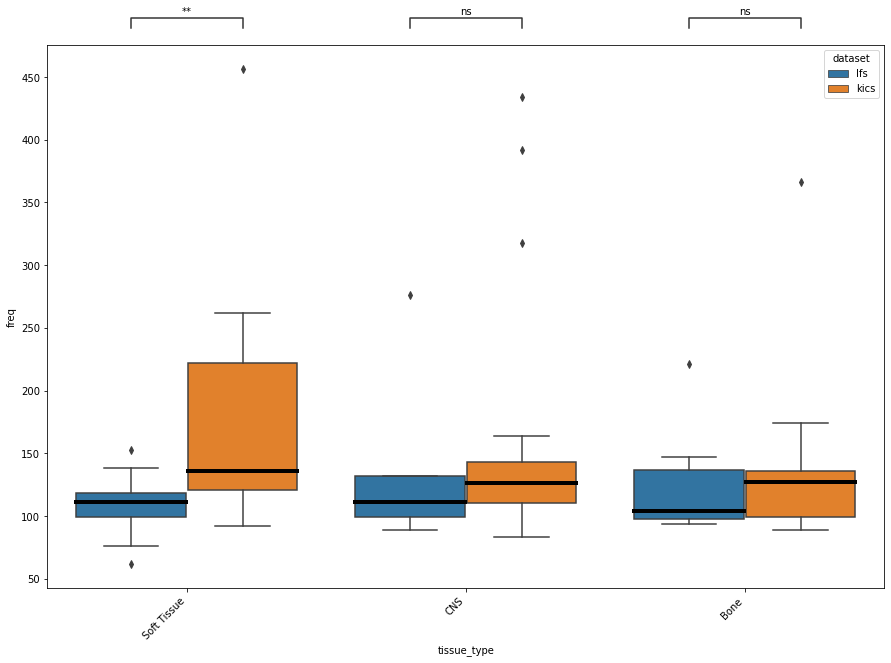

In [109]:
#print(kDel['tissue_type'].unique())
#print(lDel['tissue_type'].unique())
print(uniqueTissue)

graphSVTissue(kDel, lDel, uniqueTissue, True)

# for i in uniqueLabels:
#     print(i)
#     dog = normKdf.loc[normKdf['chrom'] == i]
#     list1 = dog['normalized'].tolist()
#     cat = normLdf.loc[normLdf['chrom'] == i]
#     list2 = cat['normalized'].tolist()
#     print(mannwhitneyu(list1, list2))


LFS
   sample_id sample  tissue_type cancer_diagnosis  freq dataset tumour_class  \
9       2349   2349  Soft Tissue              RMS    62     lfs          NaN   
41      3763   3763  Soft Tissue              RMS   153     lfs          NaN   

   CCP germline  
9           NaN  
41          NaN  
the outliers for RMS are:
['2349', '3763']

   sample_id    sample tissue_type cancer_diagnosis  freq dataset  \
58  PD13489b  PD13489b        Bone               OS   221     lfs   

   tumour_class CCP germline  
58          NaN          NaN  
the outliers for OS are:
['PD13489b']

KICS
   sample_id sample  tissue_type cancer_diagnosis  freq dataset  tumour_class  \
14    284386    NaN  Soft Tissue              RMS   456    kics  SOLID TUMORS   

   CCP germline  
14       284386  
the outliers for RMS are:
['284386']

  sample_id sample tissue_type cancer_diagnosis  freq dataset  tumour_class  \
7    271112    NaN        Bone               OS   366    kics  SOLID TUMORS   

  CCP germline  

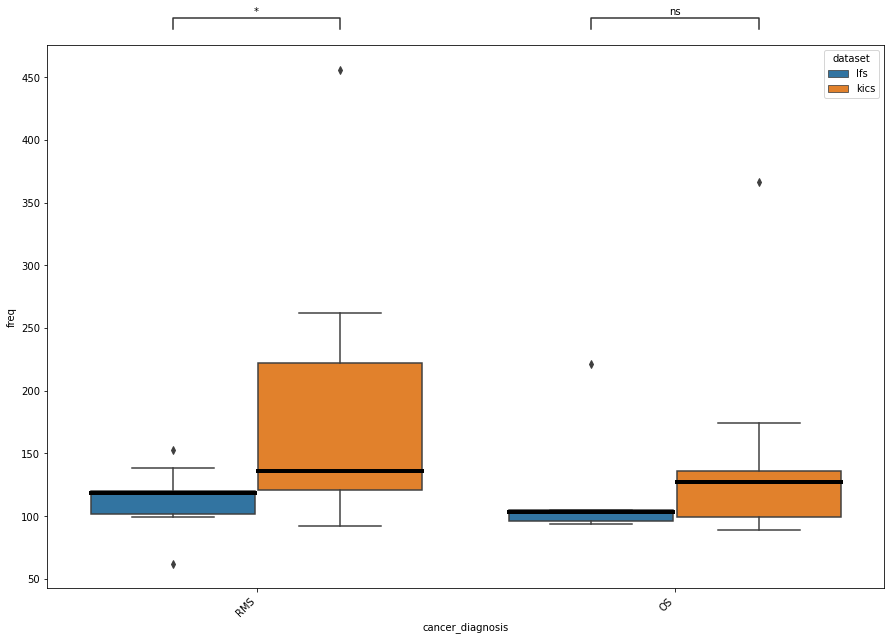

In [110]:
#print(lDel.head(50))

graphSVTissue(kDel, lDel, uniqueDiag, False)


## DUP

['CNS', 'Soft Tissue', 'Blood', 'Bone', 'Other', 'US', 'Thyroid', 'Breast', 'Colon', 'Adrenal', 'Ovaries']
LFS
   sample_id sample  tissue_type cancer_diagnosis  freq dataset tumour_class  \
49      4329   4329  Soft Tissue              RMS    14     lfs          NaN   

   CCP germline  
49          NaN  
the outliers for Soft Tissue are:
['4329']

   sample_id sample tissue_type cancer_diagnosis  freq dataset tumour_class  \
27      3356   3356         CNS              CPC    30     lfs          NaN   

   CCP germline  
27          NaN  
the outliers for CNS are:
['3356']

   sample_id sample tissue_type cancer_diagnosis  freq dataset tumour_class  \
25      3332   3332        Bone               OS     6     lfs          NaN   

   CCP germline  
25          NaN  
the outliers for Bone are:
['3332']

KICS
   sample_id sample tissue_type cancer_diagnosis  freq dataset  tumour_class  \
9     271116    NaN         CNS       Meningioma    33    kics    CNS TUMORS   
16    286909    NaN 

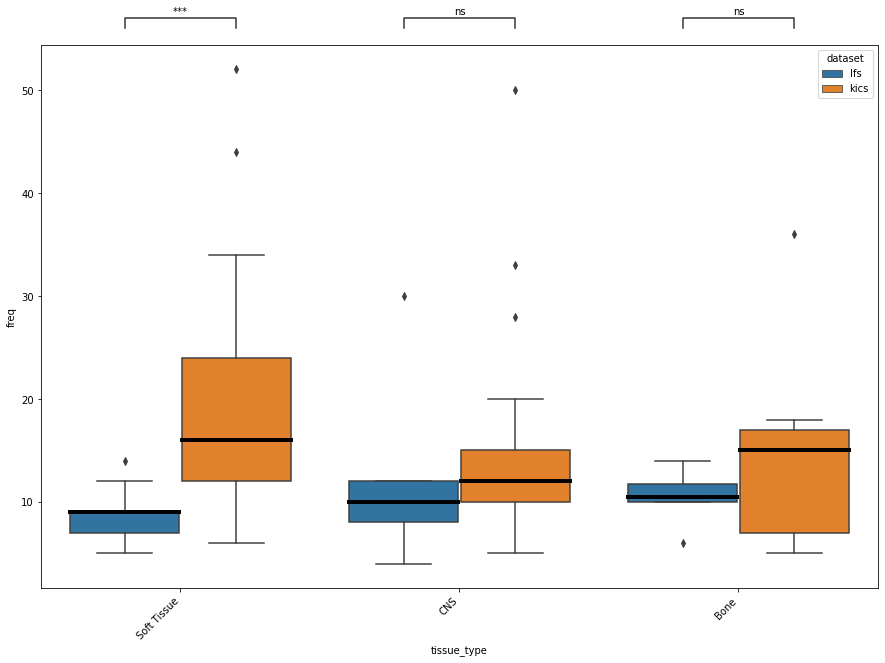

In [111]:
print(kicsTissueList)
graphSVTissue(kDup, lDup, uniqueTissue, True)


LFS
   sample_id sample  tissue_type cancer_diagnosis  freq dataset tumour_class  \
47      4227   4227  Soft Tissue              RMS    12     lfs          NaN   
49      4329   4329  Soft Tissue              RMS    14     lfs          NaN   

   CCP germline  
47          NaN  
49          NaN  
the outliers for RMS are:
['4227', '4329']

   sample_id sample tissue_type cancer_diagnosis  freq dataset tumour_class  \
25      3332   3332        Bone               OS     6     lfs          NaN   

   CCP germline  
25          NaN  
the outliers for OS are:
['3332']

KICS
   sample_id sample  tissue_type cancer_diagnosis  freq dataset  tumour_class  \
14    284386    NaN  Soft Tissue              RMS    52    kics  SOLID TUMORS   
79    326693    NaN  Soft Tissue              RMS    44    kics  SOLID TUMORS   

   CCP germline  
14       284386  
79       326693  
the outliers for RMS are:
['284386', '326693']

  sample_id sample tissue_type cancer_diagnosis  freq dataset  tumour_class 

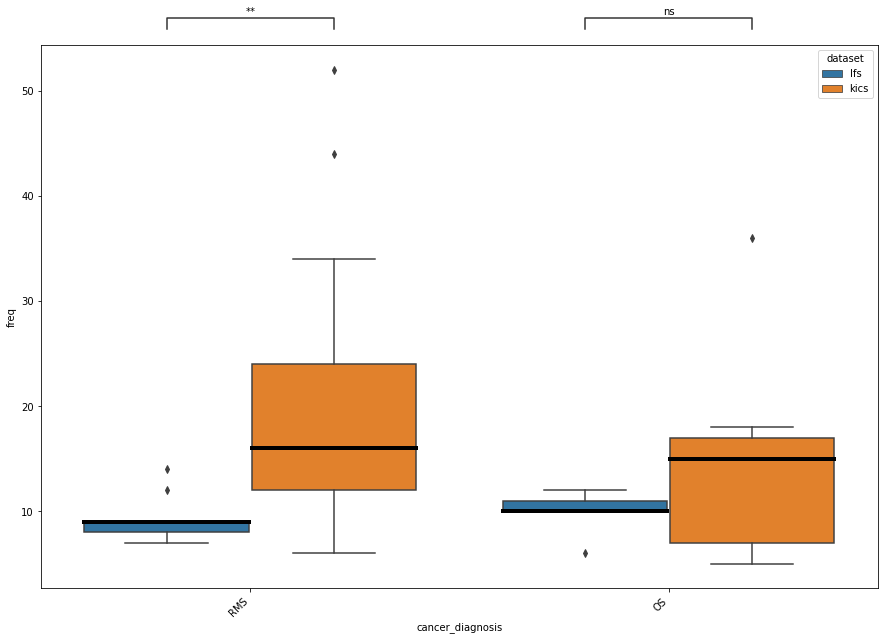

In [112]:
graphSVTissue(kDup, lDup, uniqueDiag, False)


## INV

LFS
Empty DataFrame
Columns: [sample_id, sample, tissue_type, cancer_diagnosis, freq, dataset, tumour_class, CCP germline]
Index: []
the outliers for Soft Tissue are:
[]

   sample_id sample tissue_type cancer_diagnosis  freq dataset tumour_class  \
27      3356   3356         CNS              CPC    16     lfs          NaN   

   CCP germline  
27          NaN  
the outliers for CNS are:
['3356']

   sample_id    sample tissue_type cancer_diagnosis  freq dataset  \
57  PD13489b  PD13489b        Bone               OS    10     lfs   

   tumour_class CCP germline  
57          NaN          NaN  
the outliers for Bone are:
['PD13489b']

KICS
   sample_id sample tissue_type cancer_diagnosis  freq dataset  tumour_class  \
9     271116    NaN         CNS       Meningioma    18    kics    CNS TUMORS   
16    286909    NaN         CNS           Glioma    22    kics    CNS TUMORS   
36    300683    NaN         CNS           Glioma    30    kics  SOLID TUMORS   

   CCP germline  
9        271

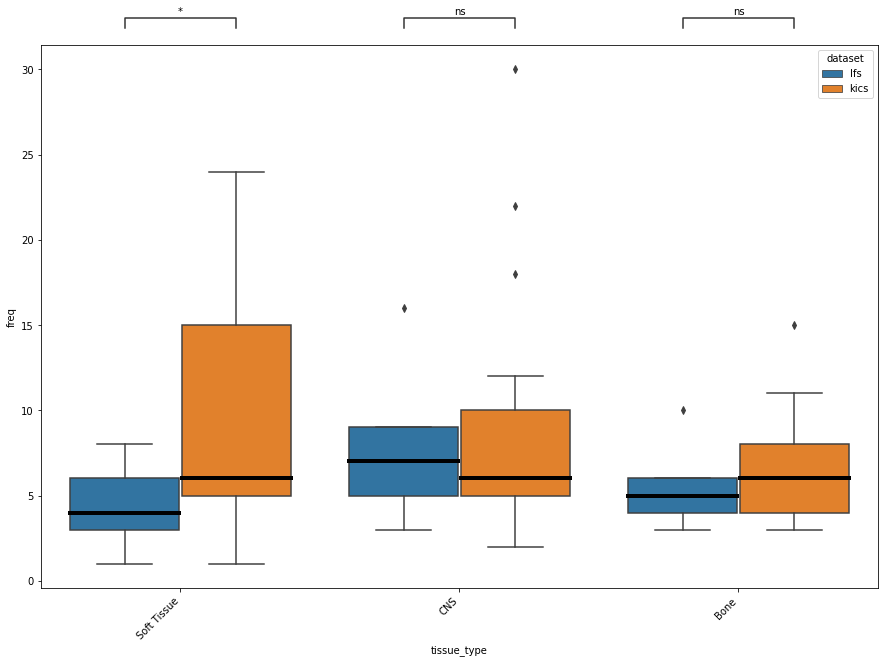

In [113]:
graphSVTissue(kInv, lInv, uniqueTissue, True)

LFS
   sample_id sample  tissue_type cancer_diagnosis  freq dataset tumour_class  \
49      4329   4329  Soft Tissue              RMS     8     lfs          NaN   

   CCP germline  
49          NaN  
the outliers for RMS are:
['4329']

   sample_id    sample tissue_type cancer_diagnosis  freq dataset  \
57  PD13489b  PD13489b        Bone               OS    10     lfs   

   tumour_class CCP germline  
57          NaN          NaN  
the outliers for OS are:
['PD13489b']

KICS
Empty DataFrame
Columns: [sample_id, sample, tissue_type, cancer_diagnosis, freq, dataset, tumour_class, CCP germline]
Index: []
the outliers for RMS are:
[]

  sample_id sample tissue_type cancer_diagnosis  freq dataset  tumour_class  \
7    271112    NaN        Bone               OS    15    kics  SOLID TUMORS   

  CCP germline  
7       271112  
the outliers for OS are:
['271112']

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***

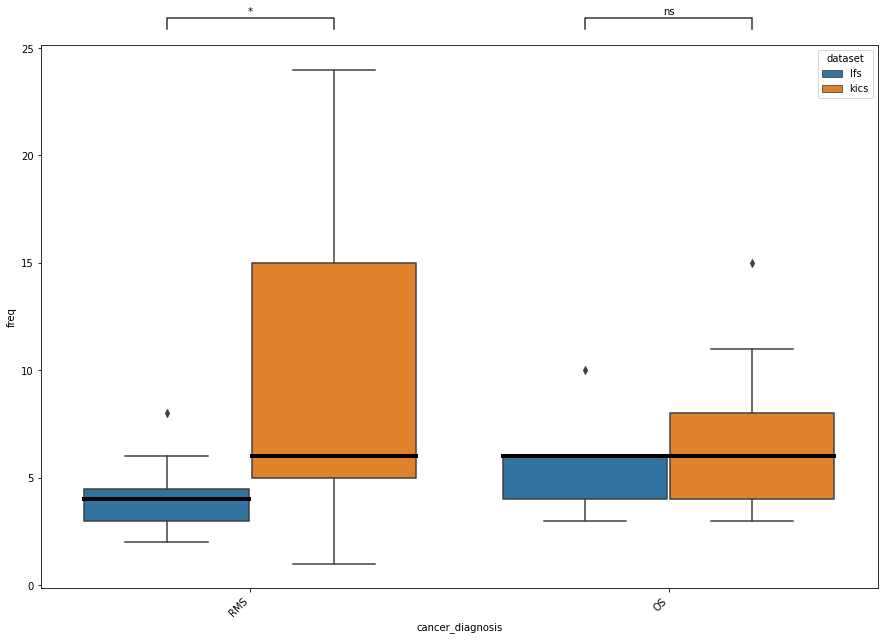

In [114]:
graphSVTissue(kInv, lInv, uniqueDiag, False)


In [115]:
"""
rare variants first >done
LFS vs Kics for Diagnosis type >done 
hypothesis tests >done
LFS vs unaffected >done?
"""



'\nrare variants first >done\nLFS vs Kics for Diagnosis type >done \nhypothesis tests >done\nLFS vs unaffected >done?\n'

In [158]:
def boxplotPoints(title:list, column:list, df: pd.DataFrame , sizeH=20.50, sizeV=17.50, col='red', trans=0.25):    
    plt.rcParams["figure.figsize"] = [sizeH, sizeV]
    plt.rcParams["figure.autolayout"] = True
    data = pd.DataFrame({
        t: df[c] for t,c in zip(title, column)})
    
    #print(data)
    plotTest = data
    plotTest = plotTest.stack().to_frame().reset_index().rename(columns={'level_1': 'iden', 0: 'value'}).drop('level_0', axis='columns')
    #print(plotTest.head(50))
    #data.boxplot()
    #BoxGraphMulti(plotTest, 'cat', 'value', 'iden')
    sns.boxplot(data=plotTest, x='iden', y='value')
        
    #plot with boxplot
    sns.stripplot(x = 'iden',
              y = 'value',
                  color = 'red',
                  alpha = 0.25,
              data = plotTest)
    
#     for i, d in enumerate(data):
#         y = data[d]
#         print(data[d].unique())
#         x = np.random.normal(i, 0.04, len(y))
#         plt.scatter(x, y, color = col, alpha = trans)
    
    list1 = df[column[0]].dropna()
    list2 = df[column[1]].dropna()
    print(mannwhitneyu(list1,list2))
    plt.show()

     sample_id  tissue_type    0
0         3356          CNS  322
1     PD13489b         Bone  242
2         3425      Adrenal  225
3         3365      Adrenal  212
4   SJACT005_G      Adrenal  196
..         ...          ...  ...
60        2565   Unaffected   85
61        1357   Unaffected   83
62        2349  Soft Tissue   73
63        2447   Unaffected   62
64        2765      Adrenal   61

[65 rows x 3 columns]
  sample_id tissue_type    0
0      3356         CNS  322
the outliers for CNS are:
['3356']

  sample_id tissue_type    0
1  PD13489b        Bone  242
the outliers for Bone are:
['PD13489b']

Empty DataFrame
Columns: [sample_id, tissue_type, 0]
Index: []
the outliers for Adrenal are:
[]

   sample_id  tissue_type    0
7       3763  Soft Tissue  164
62      2349  Soft Tissue   73
the outliers for Soft Tissue are:
['3763', '2349']

   sample_id tissue_type    0
12      4257      Breast  153
the outliers for Breast are:
['4257']

   sample_id tissue_type   0
63      2447  Unaf

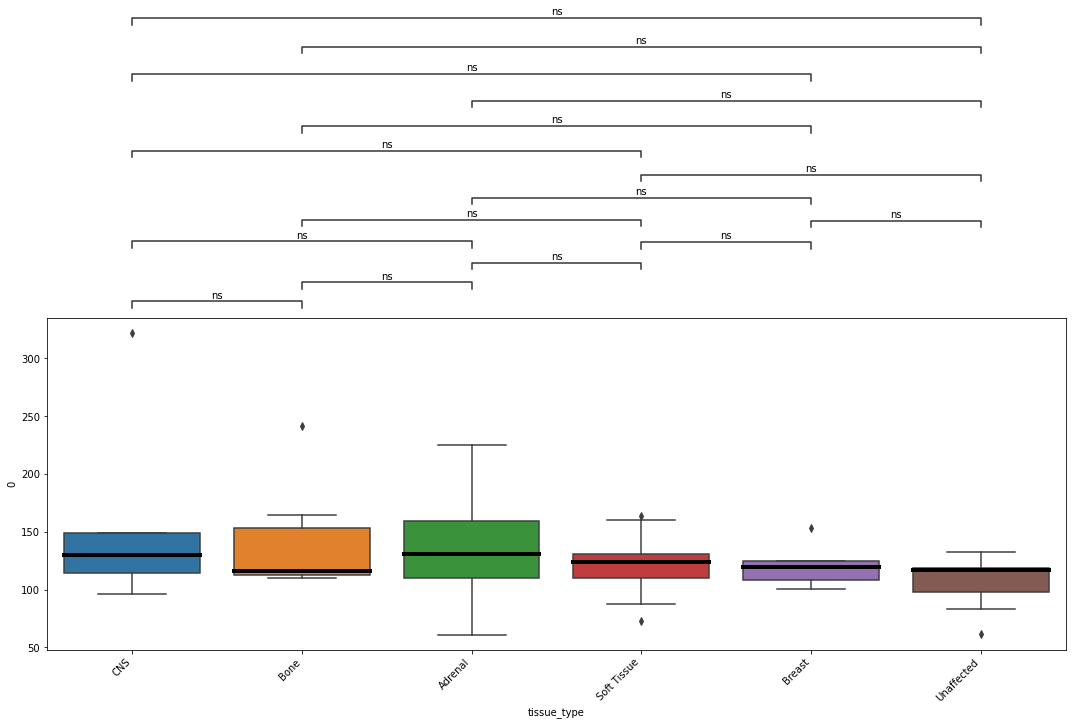

In [167]:
"""
Between Cancer Types
Make an LFS graph, a KiCS Graph
- SV Specific
- Overall <Done
"""


def graphBoxGen(xColumnName, df, ycol = 0):
    print(df)
    
    df = filterBig(df, xColumnName)
    outliersInDf(df,xColumnName,ycol)

    plt.rcParams["figure.figsize"] = [15, 10]
    ax = sns.boxplot(data=df, x=xColumnName, y=ycol, medianprops={"linewidth": 4, 'color':'black'})
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha="right")

    #add statistical test here

    # initializing list
    uniqueTissue = list(df[xColumnName].unique()) 

    #does all possible pairings given a list
    listPairing = [(a,b) for x, a in enumerate(uniqueTissue) for b in uniqueTissue[x+1:]]
    #print(listPairing)

    annot = Annotator(ax, listPairing, data=df, x=xColumnName, y=ycol)
    annot.configure(test='Mann-Whitney',
                    text_format='star', loc='outside', verbose=2)
    annot.apply_and_annotate()
    

#overall LFS
ldf = bigLDf.drop(['GD_AF','sample','ageofonset'], axis=1)
kdf = bigKDf.drop(['CCP germline','abbv_id','tumour_class','ageofonset'],axis=1)

#print(ldf)
ldfGenTissue = ldf.drop(['SV chrom', 'SV type', 'cancer_diagnosis'],axis=1)
ldfGenTissue = ldfGenTissue.value_counts().to_frame().reset_index()

graphBoxGen('tissue_type', ldfGenTissue)


65
Empty DataFrame
Columns: [sample_id, SV type, freq, dataset]
Index: []
the outliers for unaffected are:
[]

  sample_id SV type  freq dataset
0      3356     DEL   276  cancer
1  PD13489b     DEL   221  cancer
2      3425     DEL   195  cancer
3      3365     DEL   180  cancer
the outliers for cancer are:
['3356', 'PD13489b', '3425', '3365']

Empty DataFrame
Columns: [sample_id, SV type, freq, dataset]
Index: []
the outliers for unaffected are:
[]

    sample_id SV type  freq dataset
0  SJACT005_G     DUP    40  cancer
1        3356     DUP    30  cancer
2        2957     DUP    22  cancer
3        3425     DUP    21  cancer
the outliers for cancer are:
['SJACT005_G', '3356', '2957', '3425']

Empty DataFrame
Columns: [sample_id, SV type, freq, dataset]
Index: []
the outliers for unaffected are:
[]

    sample_id SV type  freq dataset
0        3365     INV    21  cancer
1  SJACT005_G     INV    21  cancer
2        3356     INV    16  cancer
the outliers for cancer are:
['3365', 'SJAC

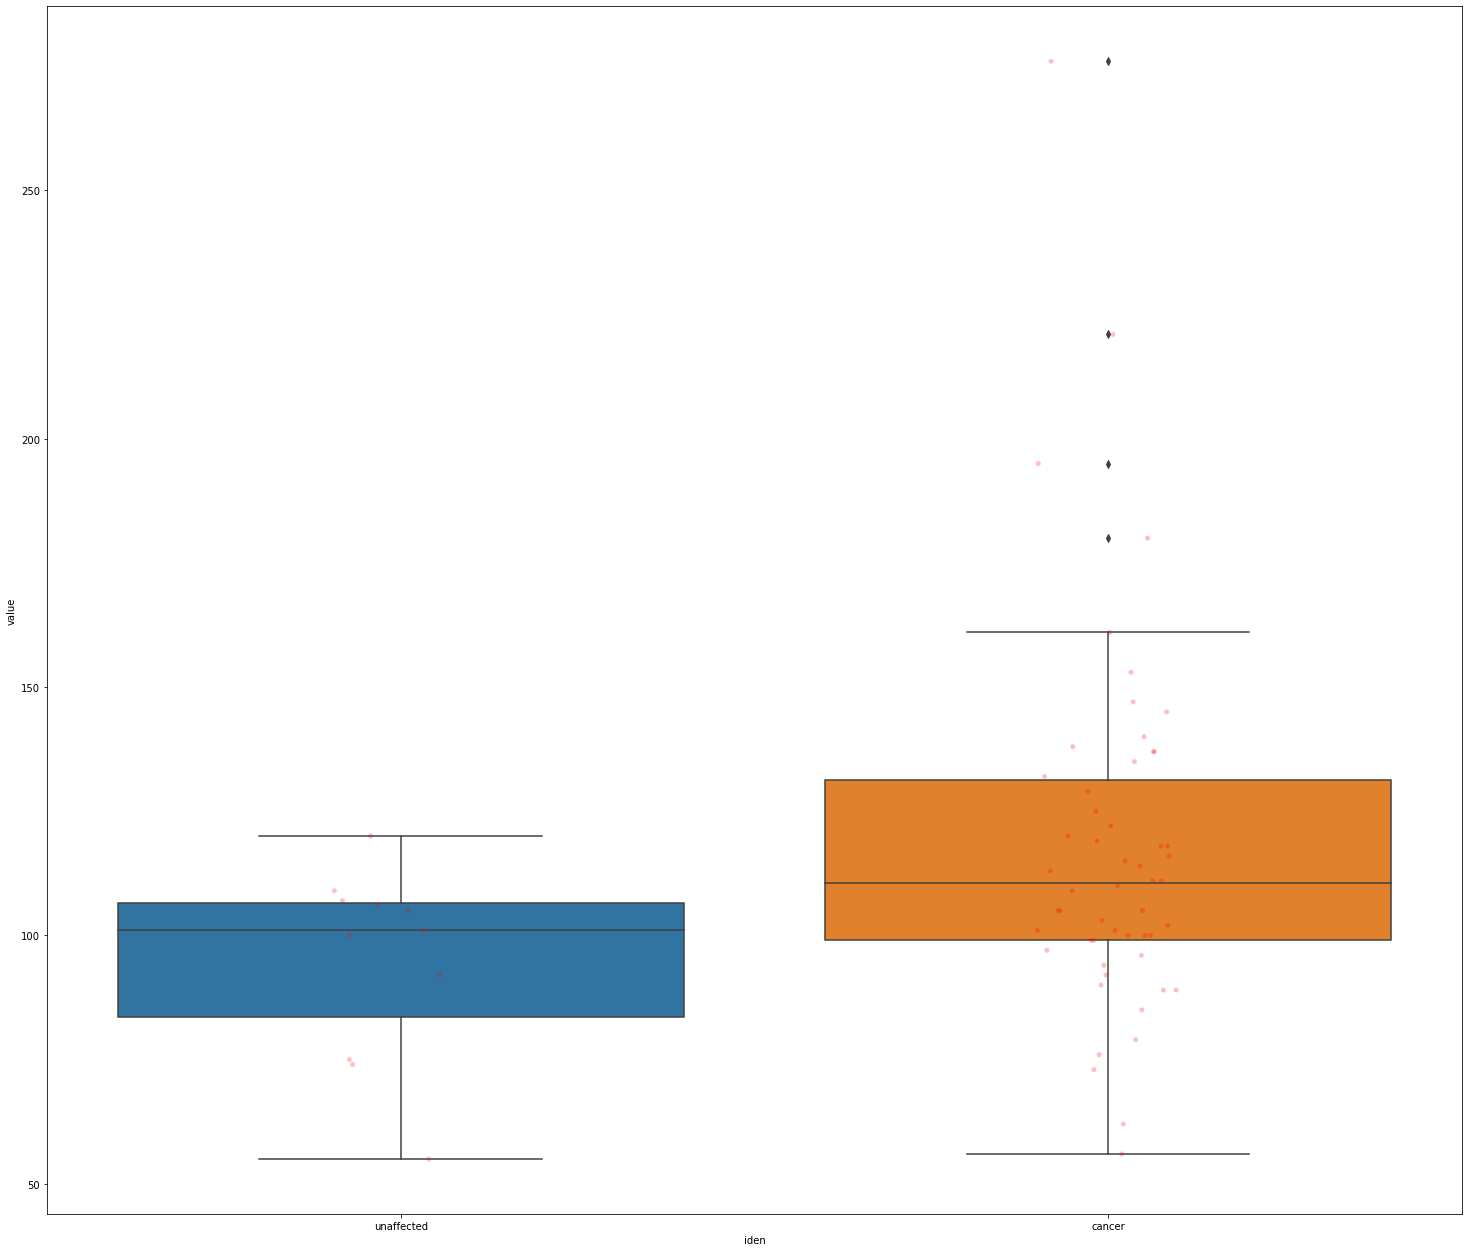

MannwhitneyuResult(statistic=266.0, pvalue=0.5920316326069894)


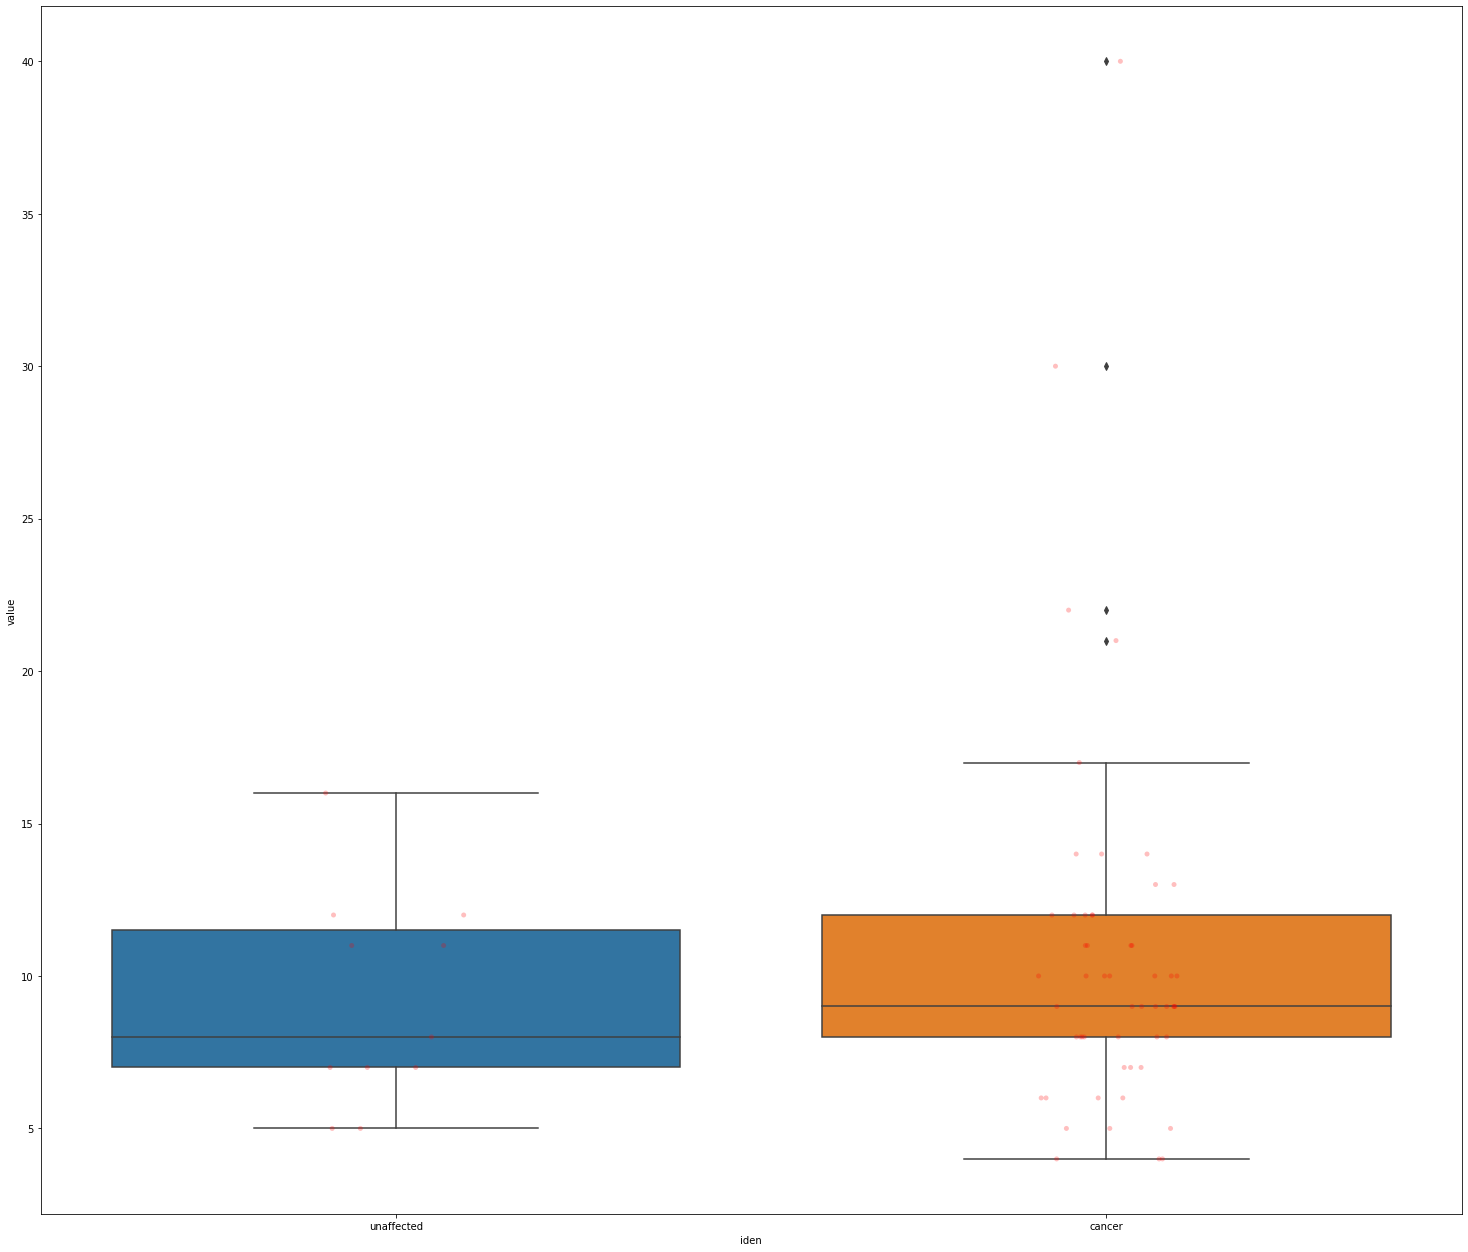

MannwhitneyuResult(statistic=191.0, pvalue=0.08454067588286607)


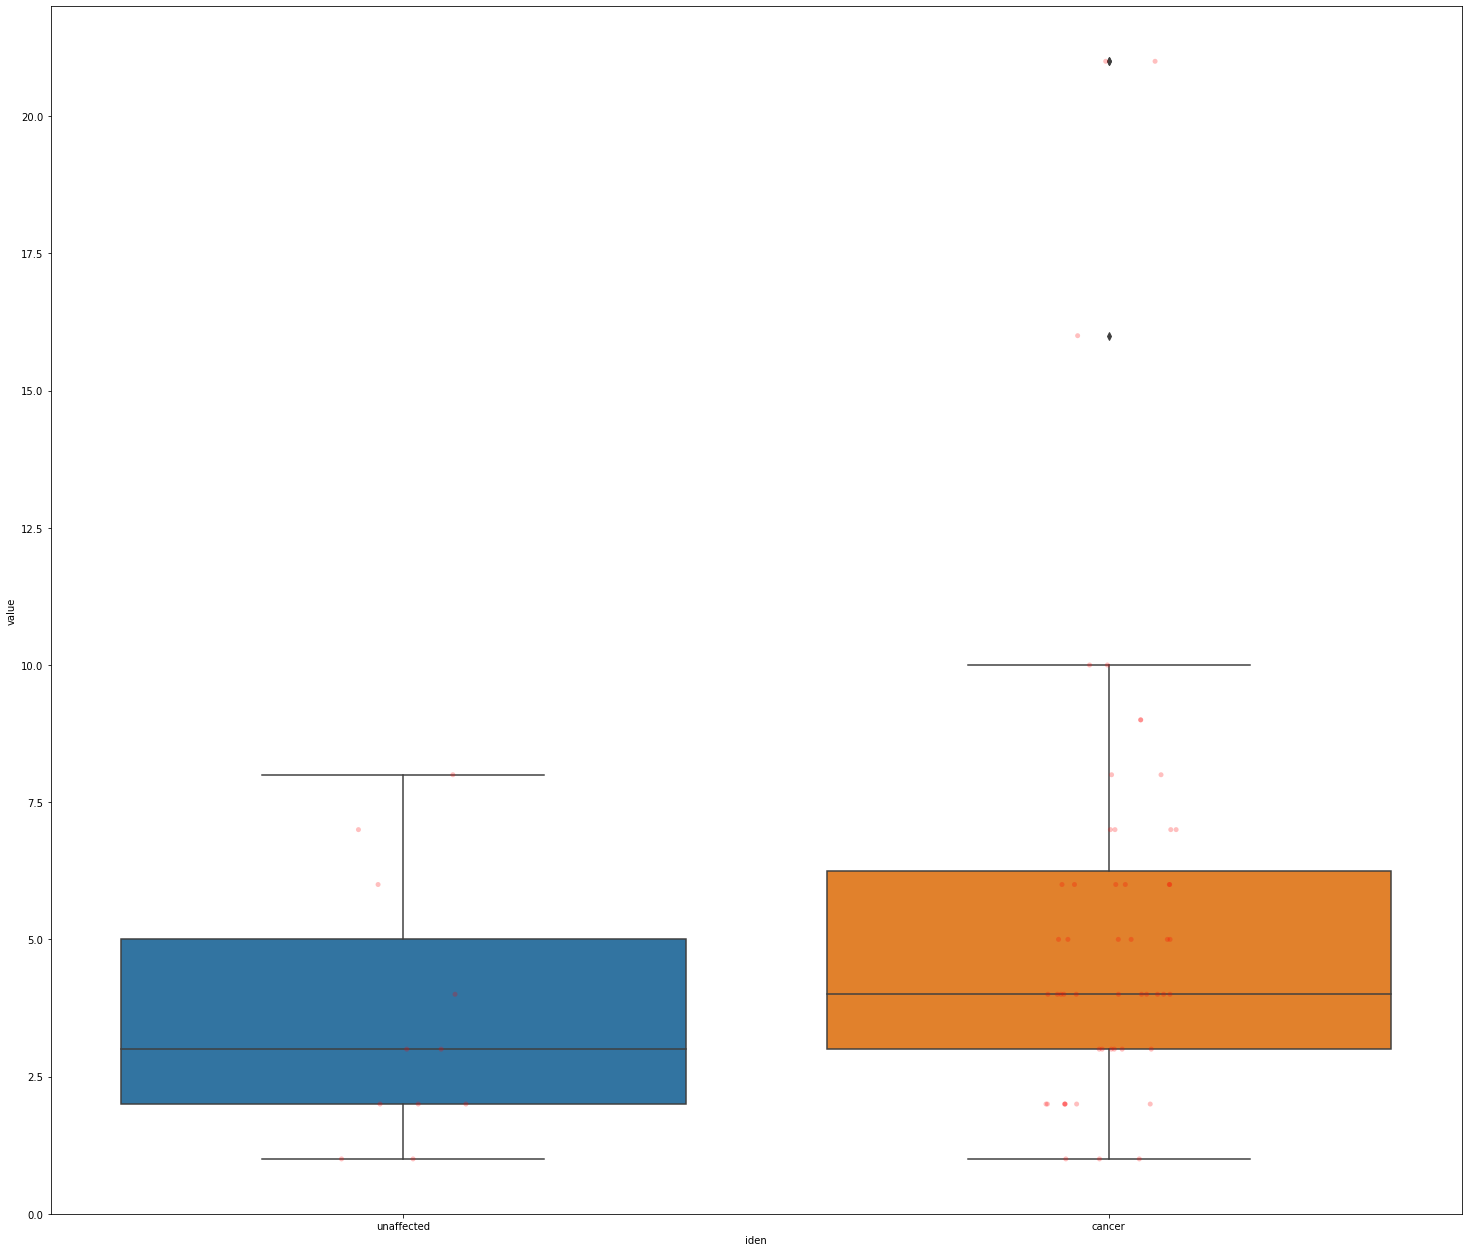

In [168]:
"""
LFS vs Unaffected
"""
#3 big graphs for SV type lfs vs unaffected

#print(bigLDf.head(20))?
# print(bigLDf['tissue_type'].unique())
# tempUnaffectedT = bigLDf[bigLDf['tissue_type']=='Unaffected']
# tempUnaffectedD = bigLDf[bigLDf['cancer_diagnosis']=='Unaffected']
# print(tempUnaffectedT['sample_id'].unique())
# print(tempUnaffectedT['cancer_diagnosis'].unique())
# print(tempUnaffectedD['sample_id'].unique())
# print(tempUnaffectedD['cancer_diagnosis'].unique())

#both the tissue_type and cancer_diagnosis have the same unaffected

unaffectedDf = bigLDf[bigLDf['tissue_type']=='Unaffected'].drop(['GD_AF', 'sample', 'tissue_type',
                                                                 'cancer_diagnosis', 'SV chrom','ageofonset'], axis=1)
cancerDf = bigLDf[bigLDf['tissue_type']!='Unaffected'].drop(['GD_AF', 'sample', 'tissue_type',
                                                             'cancer_diagnosis', 'SV chrom','ageofonset'], axis=1)
print(bigLDf['sample_id'].nunique())

uDel = unaffectedDf[unaffectedDf['SV type'] == 'DEL'].value_counts().to_frame().reset_index()
uDel = uDel.rename(columns={0:'freq'})
uDel['dataset']='unaffected'
cDel = cancerDf[cancerDf['SV type'] == 'DEL'].value_counts().to_frame().reset_index()
cDel = cDel.rename(columns={0:'freq'})
cDel['dataset']='cancer'
mergedDel = pd.DataFrame(data = {'unaffected':uDel['freq'],'cancer':cDel['freq']})

outliersInDf(pd.concat([uDel,cDel]),'dataset','freq')


uDup = unaffectedDf[unaffectedDf['SV type'] == 'DUP'].value_counts().to_frame().reset_index()
uDup = uDup.rename(columns={0:'freq'})
uDup['dataset']='unaffected'
cDup = cancerDf[cancerDf['SV type'] == 'DUP'].value_counts().to_frame().reset_index()
cDup = cDup.rename(columns={0:'freq'})
cDup['dataset']='cancer'
mergedDup = pd.DataFrame(data = {'unaffected':uDup['freq'],'cancer':cDup['freq']})

outliersInDf(pd.concat([uDup,cDup]),'dataset','freq')


uInv = unaffectedDf[unaffectedDf['SV type'] == 'INV'].value_counts().to_frame().reset_index()
uInv = uInv.rename(columns={0:'freq'})
uInv['dataset']='unaffected'
cInv = cancerDf[cancerDf['SV type'] == 'INV'].value_counts().to_frame().reset_index()
cInv = cInv.rename(columns={0:'freq'})
cInv['dataset']='cancer'
mergedInv = pd.DataFrame(data = {'unaffected':uInv['freq'],'cancer':cInv['freq']})

outliersInDf(pd.concat([uInv,cInv]),'dataset','freq')


#print(mergedInv)
title = ['unaffected','cancer']

boxplotPoints(title, title, mergedDel)
boxplotPoints(title, title, mergedDup)
boxplotPoints(title, title, mergedInv)


     sample_id cancer_diagnosis    0
0         3356              CPC  322
1     PD13489b               OS  242
2         3425              ACC  225
3         3365              ACC  212
4   SJACT005_G              ACC  196
..         ...              ...  ...
60        2565       Unaffected   85
61        1357       Unaffected   83
62        2349              RMS   73
63        2447       Unaffected   62
64        2765              ACC   61

[65 rows x 3 columns]
  sample_id cancer_diagnosis    0
1  PD13489b               OS  242
the outliers for OS are:
['PD13489b']

Empty DataFrame
Columns: [sample_id, cancer_diagnosis, 0]
Index: []
the outliers for ACC are:
[]

   sample_id cancer_diagnosis   0
62      2349              RMS  73
the outliers for RMS are:
['2349']

   sample_id cancer_diagnosis    0
12      4257           Breast  153
the outliers for Breast are:
['4257']

   sample_id cancer_diagnosis   0
63      2447       Unaffected  62
the outliers for Unaffected are:
['2447']

p-va

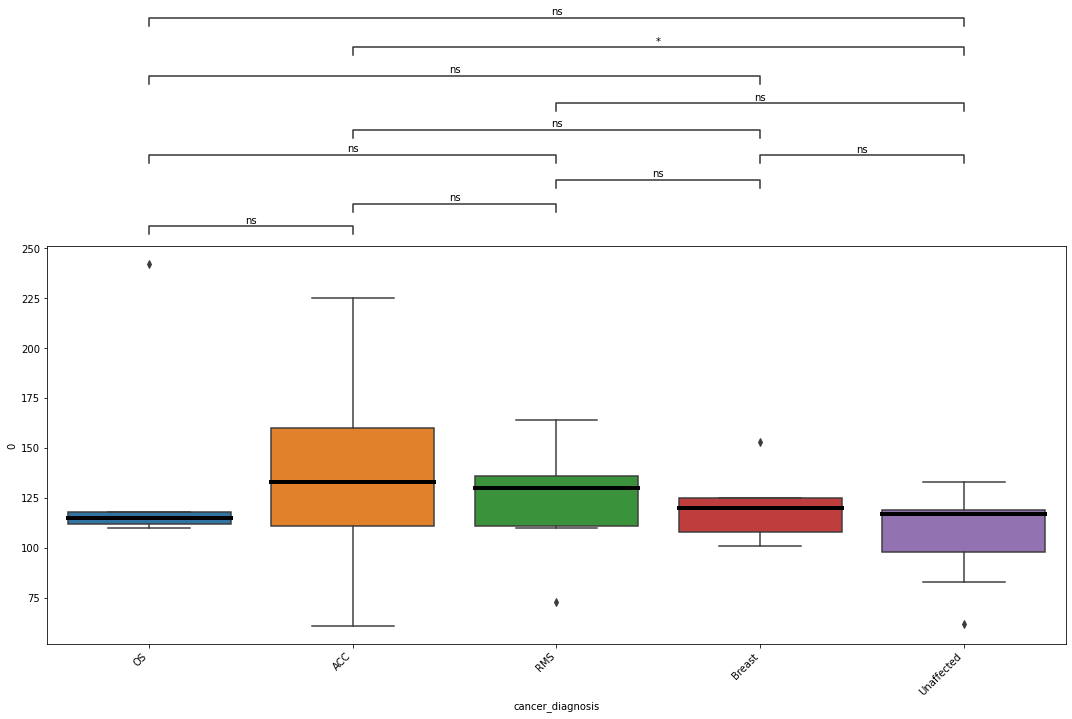

In [169]:
ldfGenDiag = ldf.drop(['SV chrom', 'SV type', 'tissue_type'],axis=1)
ldfGenDiag = ldfGenDiag.value_counts().to_frame().reset_index()

graphBoxGen('cancer_diagnosis', ldfGenDiag)

      sample_id  tissue_type    0
0        284386  Soft Tissue  532
1        286909          CNS  484
2        300683          CNS  472
3        316626        Other  447
4        271112         Bone  417
..          ...          ...  ...
88       297445          CNS  101
89       299338          CNS  100
90       305577        Other   93
91  N_-_18_2697       Breast   85
92       299321        Other   73

[93 rows x 3 columns]
      sample_id  tissue_type    0
0        284386  Soft Tissue  532
1        286909          CNS  484
2        300683          CNS  472
3        316626        Other  447
4        271112         Bone  417
..          ...          ...  ...
88       297445          CNS  101
89       299338          CNS  100
90       305577        Other   93
91  N_-_18_2697       Breast   85
92       299321        Other   73

[93 rows x 3 columns]
  sample_id  tissue_type    0
0    284386  Soft Tissue  532
the outliers for Soft Tissue are:
['284386']

  sample_id tissue_type    0
1  

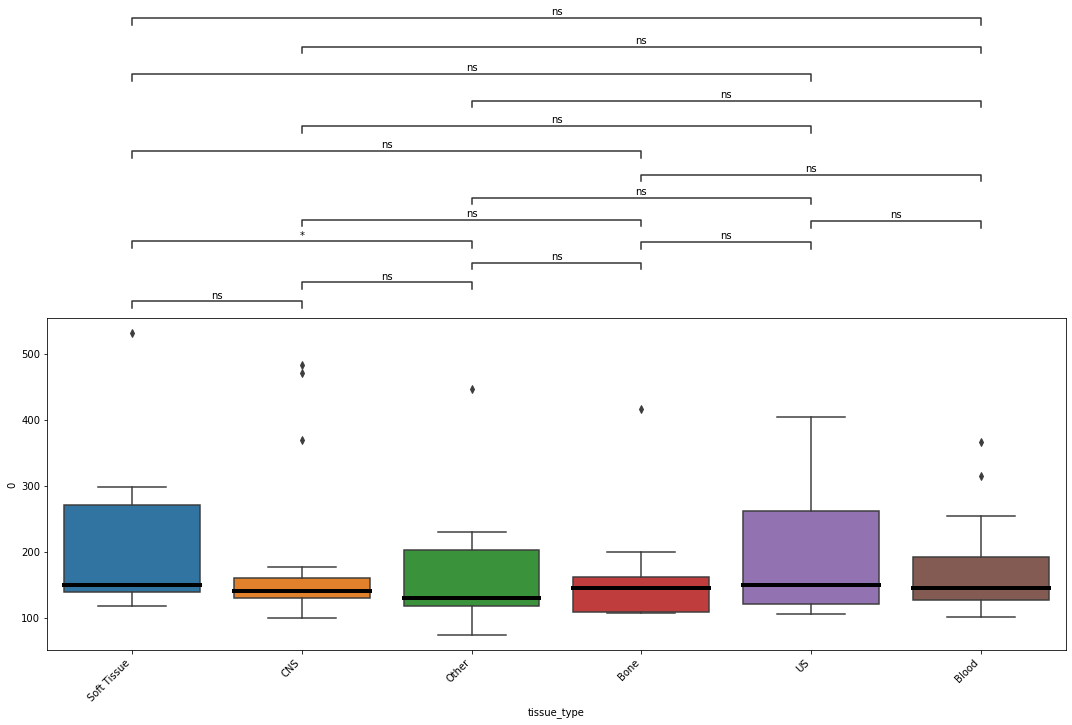

In [170]:
"""
Overall Kics
""" 
kdfGenTissue = kdf.drop(['SV type', 'cancer_diagnosis'], axis=1)
kdfGenTissue = kdfGenTissue.value_counts().to_frame().reset_index()
print(kdfGenTissue)
graphBoxGen('tissue_type', kdfGenTissue)

      sample_id cancer_diagnosis    0
0        284386              RMS  532
1        286909           Glioma  484
2        300683           Glioma  472
3        316626            Other  447
4        271112               OS  417
..          ...              ...  ...
88       297445           Glioma  101
89       299338           Glioma  100
90       305577            Other   93
91  N_-_18_2697           Breast   85
92       299321            Other   73

[93 rows x 3 columns]
  sample_id cancer_diagnosis    0
0    284386              RMS  532
the outliers for RMS are:
['284386']

  sample_id cancer_diagnosis    0
1    286909           Glioma  484
2    300683           Glioma  472
the outliers for Glioma are:
['286909', '300683']

  sample_id cancer_diagnosis    0
3    316626            Other  447
the outliers for Other are:
['316626']

  sample_id cancer_diagnosis    0
4    271112               OS  417
the outliers for OS are:
['271112']

Empty DataFrame
Columns: [sample_id, cancer_diagn

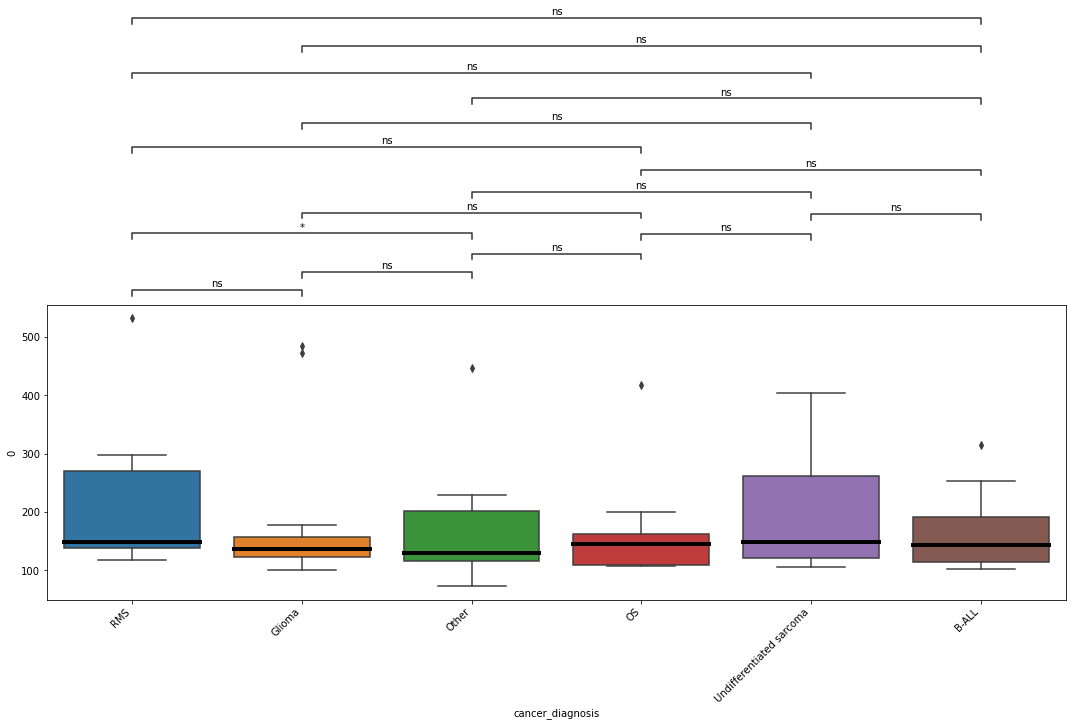

In [171]:
#overall cancer diagnosis
kdfGenDiag = kdf.drop(['SV type', 'tissue_type'], axis=1)
kdfGenDiag = kdfGenDiag.value_counts().to_frame().reset_index()
graphBoxGen('cancer_diagnosis', kdfGenDiag)

SV type    sample_id  tissue_type  DEL
0            18_1508        Other  191
1            18_1605        Blood   85
2            18_2028          CNS  143
3            18_4155          CNS  126
4            18_4156  Soft Tissue  136
..               ...          ...  ...
88              5547         Bone  113
89       N_-_18_2697       Breast   72
90       N_-_18_5639  Soft Tissue  131
91        N_-_318953        Blood  124
92        N_-_333809  Soft Tissue  121

[93 rows x 3 columns]
SV type sample_id tissue_type  DEL
65         316626       Other  393
the outliers for Other are:
['316626']

SV type sample_id tissue_type  DEL
66         316747       Blood  302
72         319104       Blood  258
the outliers for Blood are:
['316747', '319104']

SV type sample_id tissue_type  DEL
9          271116         CNS  318
16         286909         CNS  434
36         300683         CNS  392
the outliers for CNS are:
['271116', '286909', '300683']

SV type sample_id  tissue_type  DEL
14        

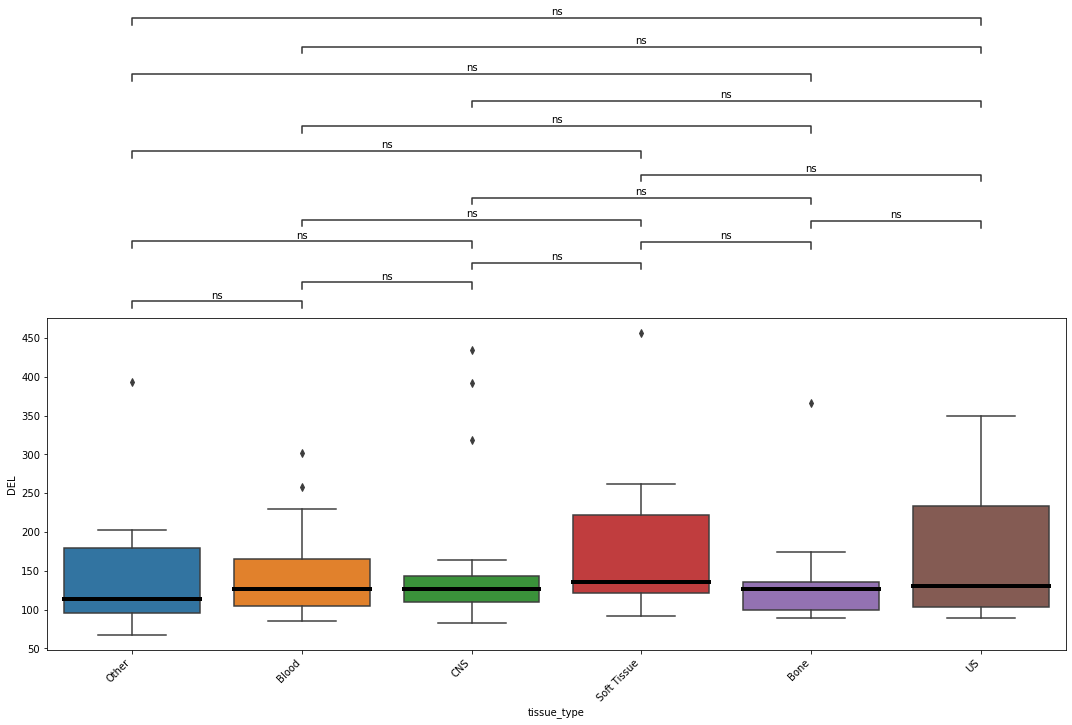

In [172]:
"""
SV Specific
"""
#Overall tissue ones
kT = kdf.drop(['cancer_diagnosis'], axis=1).groupby(['sample_id', 'SV type','tissue_type']).size()
kT = kT.unstack(1)

lT = ldf.drop(['cancer_diagnosis'], axis=1).groupby(['sample_id', 'SV type', 'tissue_type']).size()
lT = lT.unstack(1)

graphBoxGen('tissue_type', kT.drop(['DUP', 'INV'], axis=1).reset_index(),'DEL')

SV type   sample_id  tissue_type    DEL
0              1087      Adrenal   73.0
1              1092  Soft Tissue  111.0
2              1355  Soft Tissue  118.0
3              1357   Unaffected   74.0
4              1476          CNS   99.0
..              ...          ...    ...
60       SJACT001_G      Adrenal  145.0
61       SJACT002_G      Adrenal  122.0
62       SJACT005_G      Adrenal  135.0
63       SJACT007_G      Adrenal  110.0
64       SJACT008_G      Adrenal  140.0

[65 rows x 3 columns]
SV type sample_id tissue_type    DEL
31           3425     Adrenal  195.0
the outliers for Adrenal are:
['3425']

SV type sample_id  tissue_type    DEL
9            2349  Soft Tissue   62.0
41           3763  Soft Tissue  153.0
the outliers for Soft Tissue are:
['2349', '3763']

Empty DataFrame
Columns: [sample_id, tissue_type, DEL]
Index: []
the outliers for Unaffected are:
[]

SV type sample_id tissue_type    DEL
27           3356         CNS  276.0
the outliers for CNS are:
['3356']

SV ty

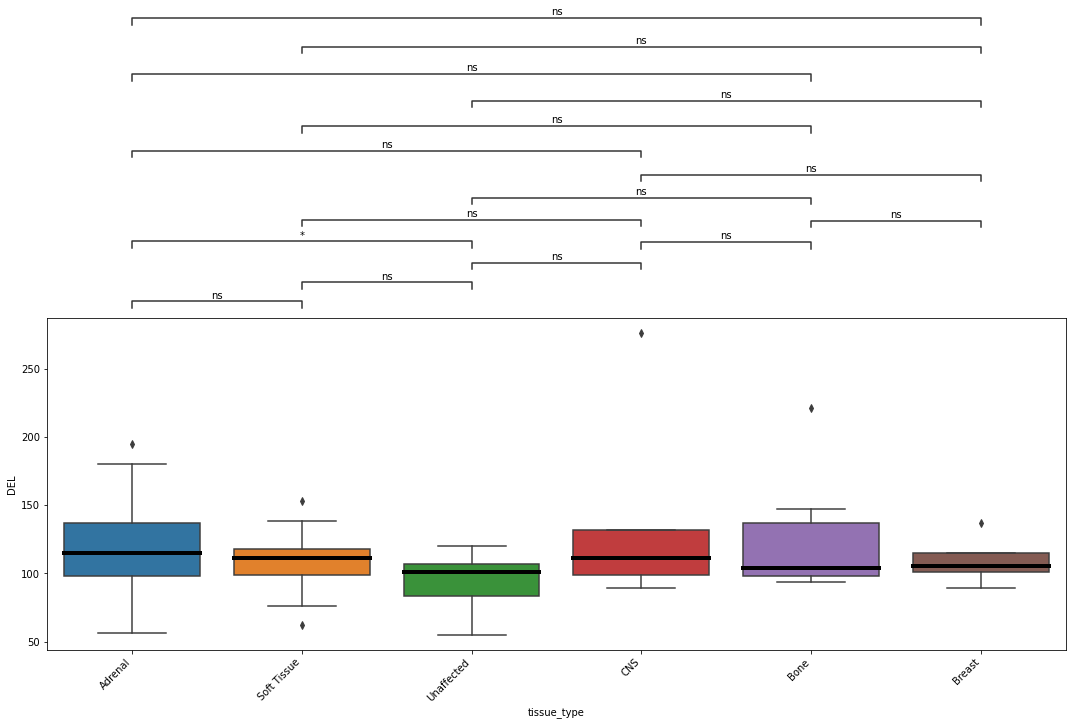

In [173]:
graphBoxGen('tissue_type', lT.drop(['DUP', 'INV'], axis=1).reset_index(),'DEL')


SV type    sample_id  tissue_type  DUP
0            18_1508        Other   22
1            18_1605        Blood   12
2            18_2028          CNS   12
3            18_4155          CNS   10
4            18_4156  Soft Tissue    6
..               ...          ...  ...
88              5547         Bone    5
89       N_-_18_2697       Breast    8
90       N_-_18_5639  Soft Tissue   12
91        N_-_318953        Blood   14
92        N_-_333809  Soft Tissue   16

[93 rows x 3 columns]
SV type sample_id tissue_type  DUP
65         316626       Other   36
the outliers for Other are:
['316626']

SV type sample_id tissue_type  DUP
66         316747       Blood   38
72         319104       Blood   35
the outliers for Blood are:
['316747', '319104']

SV type sample_id tissue_type  DUP
9          271116         CNS   33
16         286909         CNS   28
36         300683         CNS   50
the outliers for CNS are:
['271116', '286909', '300683']

SV type sample_id  tissue_type  DUP
14        

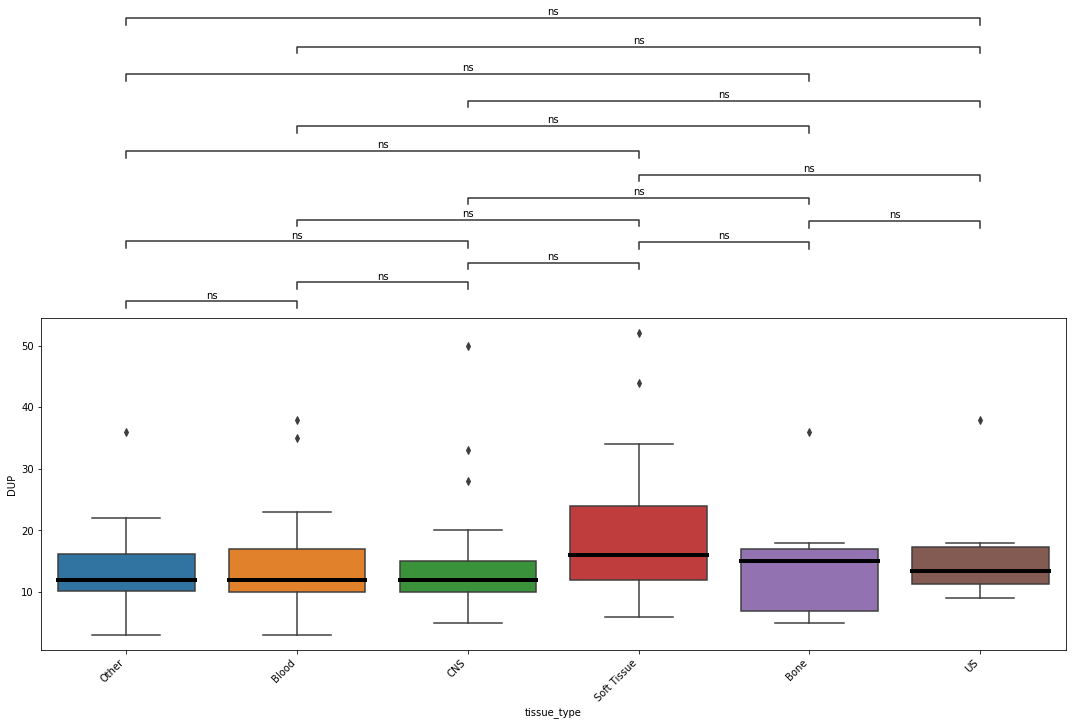

In [174]:
graphBoxGen('tissue_type', kT.drop(['DEL', 'INV'], axis=1).reset_index(),'DUP')

SV type   sample_id  tissue_type   DUP
0              1087      Adrenal   8.0
1              1092  Soft Tissue   8.0
2              1355  Soft Tissue   9.0
3              1357   Unaffected   7.0
4              1476          CNS  10.0
..              ...          ...   ...
60       SJACT001_G      Adrenal  13.0
61       SJACT002_G      Adrenal  11.0
62       SJACT005_G      Adrenal  40.0
63       SJACT007_G      Adrenal  11.0
64       SJACT008_G      Adrenal  17.0

[65 rows x 3 columns]
SV type   sample_id tissue_type   DUP
20             2957     Adrenal  22.0
31             3425     Adrenal  21.0
62       SJACT005_G     Adrenal  40.0
the outliers for Adrenal are:
['2957', '3425', 'SJACT005_G']

SV type sample_id  tissue_type   DUP
49           4329  Soft Tissue  14.0
the outliers for Soft Tissue are:
['4329']

Empty DataFrame
Columns: [sample_id, tissue_type, DUP]
Index: []
the outliers for Unaffected are:
[]

SV type sample_id tissue_type   DUP
27           3356         CNS  30.0
the

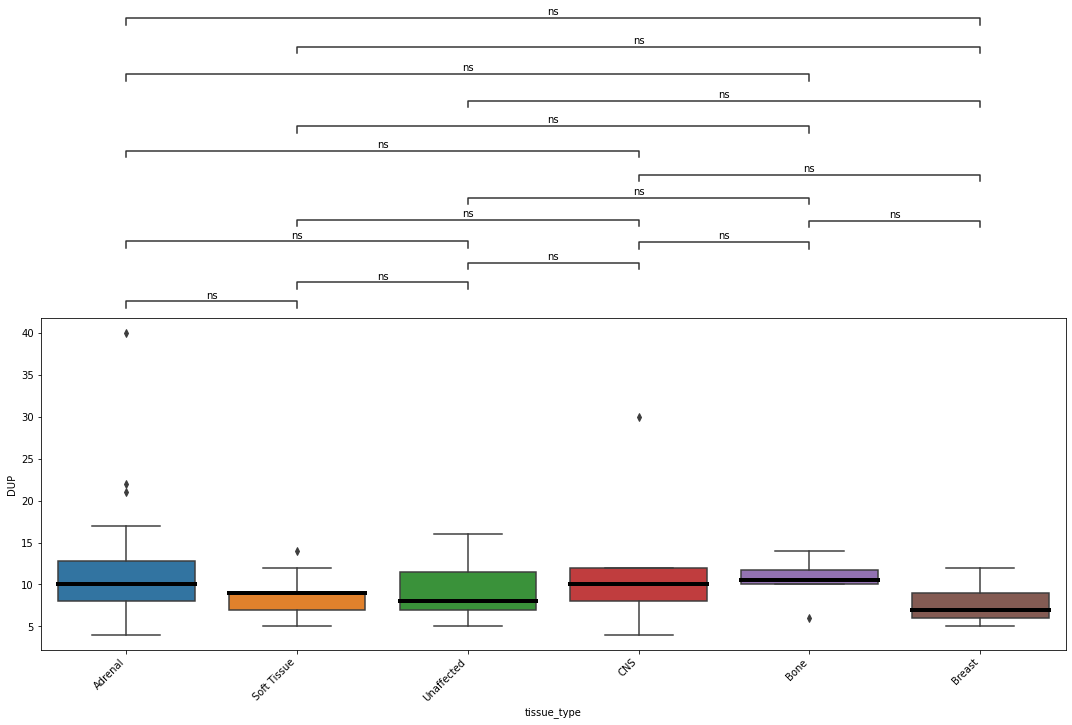

In [175]:
graphBoxGen('tissue_type', lT.drop(['DEL', 'INV'], axis=1).reset_index(),'DUP')

SV type    sample_id  tissue_type  INV
0            18_1508        Other   13
1            18_1605        Blood    4
2            18_2028          CNS    5
3            18_4155          CNS    4
4            18_4156  Soft Tissue    5
..               ...          ...  ...
88              5547         Bone    7
89       N_-_18_2697       Breast    5
90       N_-_18_5639  Soft Tissue    5
91        N_-_318953        Blood    6
92        N_-_333809  Soft Tissue    1

[93 rows x 3 columns]
Empty DataFrame
Columns: [sample_id, tissue_type, INV]
Index: []
the outliers for Other are:
[]

SV type sample_id tissue_type  INV
66         316747       Blood   27
72         319104       Blood   22
the outliers for Blood are:
['316747', '319104']

SV type sample_id tissue_type  INV
9          271116         CNS   18
16         286909         CNS   22
36         300683         CNS   30
the outliers for CNS are:
['271116', '286909', '300683']

Empty DataFrame
Columns: [sample_id, tissue_type, INV]
Inde

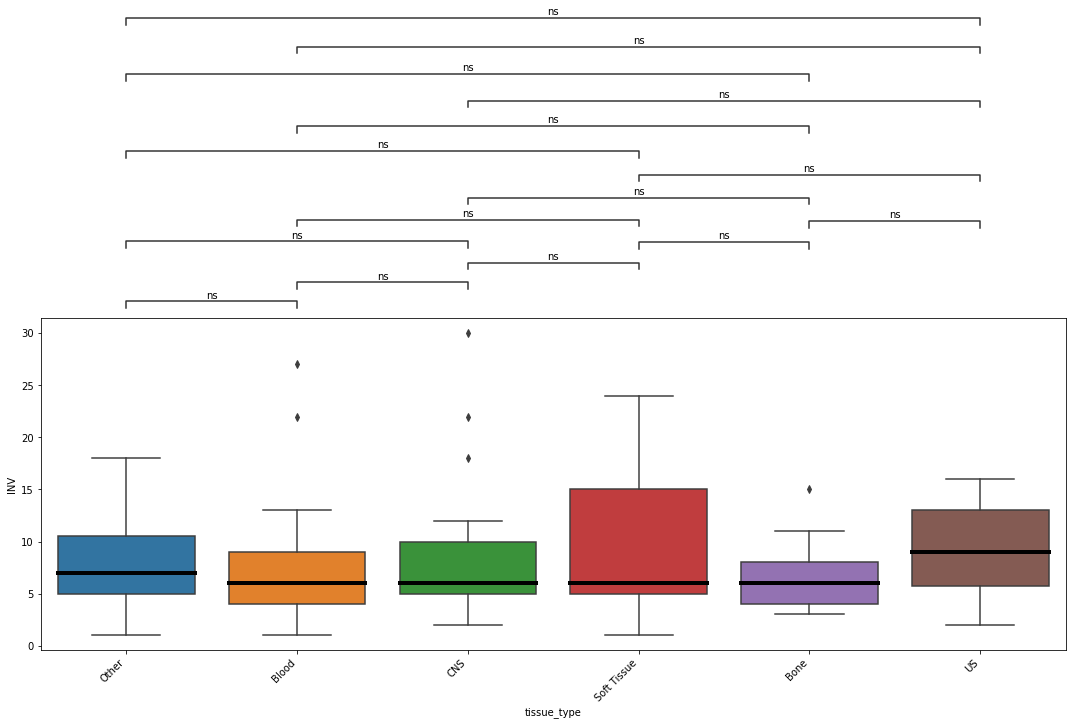

In [176]:
graphBoxGen('tissue_type', kT.drop(['DUP', 'DEL'], axis=1).reset_index(),'INV')

SV type   sample_id  tissue_type   INV
0              1087      Adrenal   4.0
1              1092  Soft Tissue   5.0
2              1355  Soft Tissue   3.0
3              1357   Unaffected   2.0
4              1476          CNS   5.0
..              ...          ...   ...
60       SJACT001_G      Adrenal   2.0
61       SJACT002_G      Adrenal   NaN
62       SJACT005_G      Adrenal  21.0
63       SJACT007_G      Adrenal   5.0
64       SJACT008_G      Adrenal   4.0

[65 rows x 3 columns]
SV type   sample_id tissue_type   INV
29             3365     Adrenal  21.0
62       SJACT005_G     Adrenal  21.0
the outliers for Adrenal are:
['3365', 'SJACT005_G']

Empty DataFrame
Columns: [sample_id, tissue_type, INV]
Index: []
the outliers for Soft Tissue are:
[]

Empty DataFrame
Columns: [sample_id, tissue_type, INV]
Index: []
the outliers for Unaffected are:
[]

SV type sample_id tissue_type   INV
27           3356         CNS  16.0
the outliers for CNS are:
['3356']

SV type sample_id tissue_typ

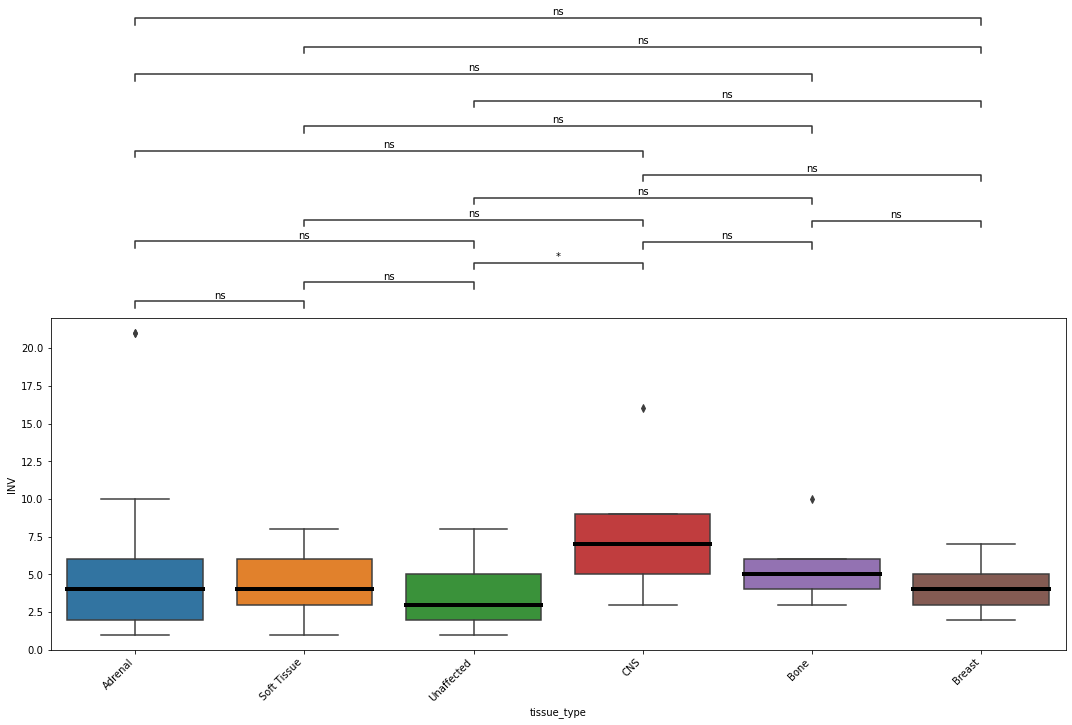

In [177]:
graphBoxGen('tissue_type', lT.drop(['DUP', 'DEL'], axis=1).reset_index(),'INV')

SV type    sample_id cancer_diagnosis  DEL
0            18_1508            Other  191
1            18_1605            T-NHL   85
2            18_2028           Glioma  143
3            18_4155           Glioma  126
4            18_4156              RMS  136
..               ...              ...  ...
88              5547               OS  113
89       N_-_18_2697           Breast   72
90       N_-_18_5639              RMS  131
91        N_-_318953            B-ALL  124
92        N_-_333809              RMS  121

[93 rows x 3 columns]
SV type sample_id cancer_diagnosis  DEL
65         316626            Other  393
the outliers for Other are:
['316626']

SV type sample_id cancer_diagnosis  DEL
16         286909           Glioma  434
36         300683           Glioma  392
the outliers for Glioma are:
['286909', '300683']

SV type sample_id cancer_diagnosis  DEL
14         284386              RMS  456
the outliers for RMS are:
['284386']

SV type sample_id cancer_diagnosis  DEL
7          2

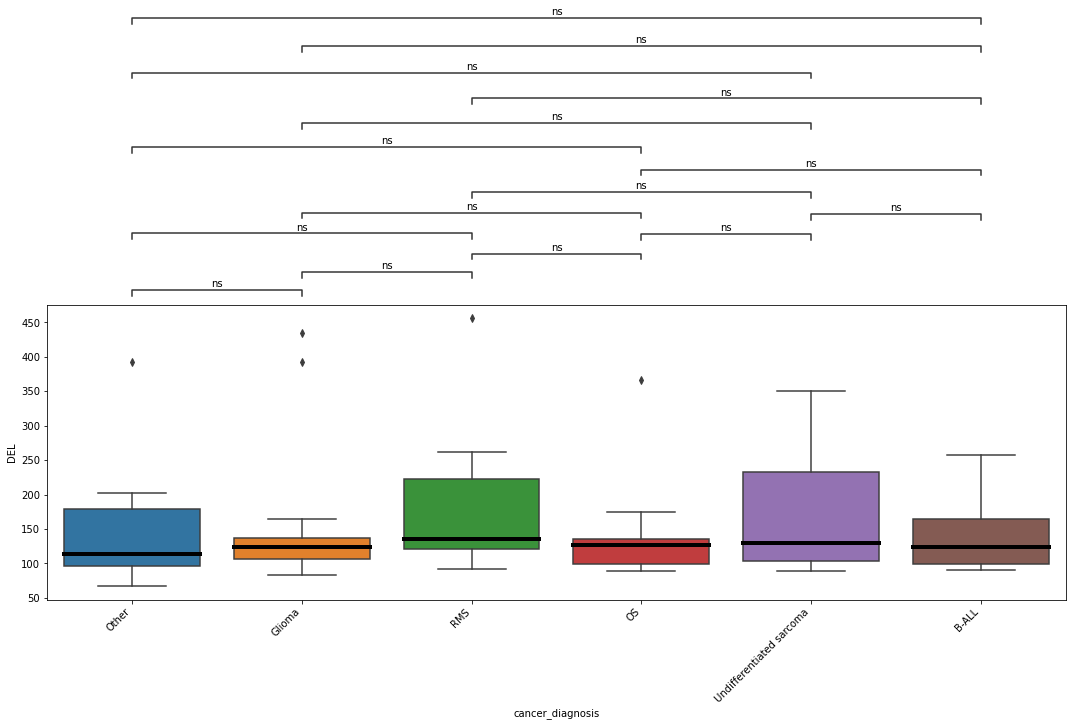

In [178]:
#diganosis, SV Specific
kD = kdf.drop(['tissue_type'], axis=1).groupby(['sample_id', 'SV type','cancer_diagnosis']).size()
kD = kD.unstack(1)

lD = ldf.drop(['tissue_type'], axis=1).groupby(['sample_id', 'SV type','cancer_diagnosis']).size()
lD = lD.unstack(1)

graphBoxGen('cancer_diagnosis', kD.drop(['DUP', 'INV'], axis=1).reset_index(),'DEL')

SV type   sample_id cancer_diagnosis    DEL
0              1087               AA   73.0
1              1092              MFH  111.0
2              1355              RMS  118.0
3              1357       Unaffected   74.0
4              1476              CPC   99.0
..              ...              ...    ...
60       SJACT001_G              ACC  145.0
61       SJACT002_G              ACC  122.0
62       SJACT005_G              ACC  135.0
63       SJACT007_G              ACC  110.0
64       SJACT008_G              ACC  140.0

[65 rows x 3 columns]
SV type sample_id cancer_diagnosis    DEL
9            2349              RMS   62.0
41           3763              RMS  153.0
the outliers for RMS are:
['2349', '3763']

Empty DataFrame
Columns: [sample_id, cancer_diagnosis, DEL]
Index: []
the outliers for Unaffected are:
[]

SV type sample_id cancer_diagnosis    DEL
31           3425              ACC  195.0
the outliers for ACC are:
['3425']

SV type sample_id cancer_diagnosis    DEL
58       P

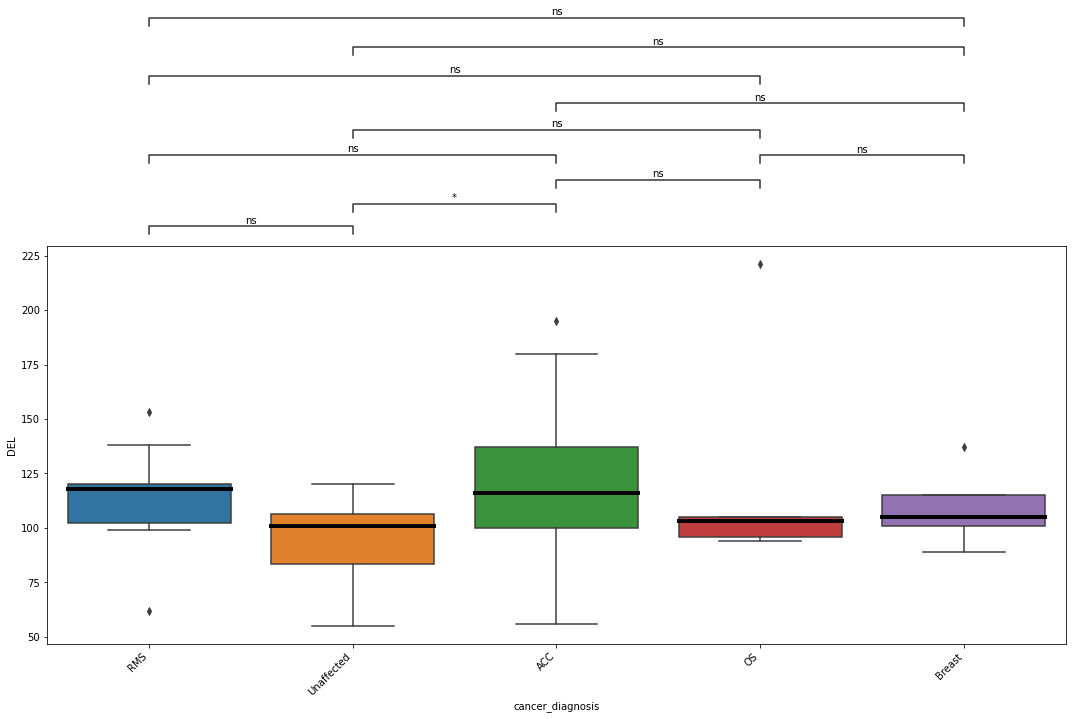

In [179]:
graphBoxGen('cancer_diagnosis', lD.drop(['DUP', 'INV'], axis=1).reset_index(),'DEL')

SV type    sample_id cancer_diagnosis  DUP
0            18_1508            Other   22
1            18_1605            T-NHL   12
2            18_2028           Glioma   12
3            18_4155           Glioma   10
4            18_4156              RMS    6
..               ...              ...  ...
88              5547               OS    5
89       N_-_18_2697           Breast    8
90       N_-_18_5639              RMS   12
91        N_-_318953            B-ALL   14
92        N_-_333809              RMS   16

[93 rows x 3 columns]
SV type sample_id cancer_diagnosis  DUP
65         316626            Other   36
the outliers for Other are:
['316626']

SV type sample_id cancer_diagnosis  DUP
16         286909           Glioma   28
36         300683           Glioma   50
the outliers for Glioma are:
['286909', '300683']

SV type sample_id cancer_diagnosis  DUP
14         284386              RMS   52
79         326693              RMS   44
the outliers for RMS are:
['284386', '326693']

SV

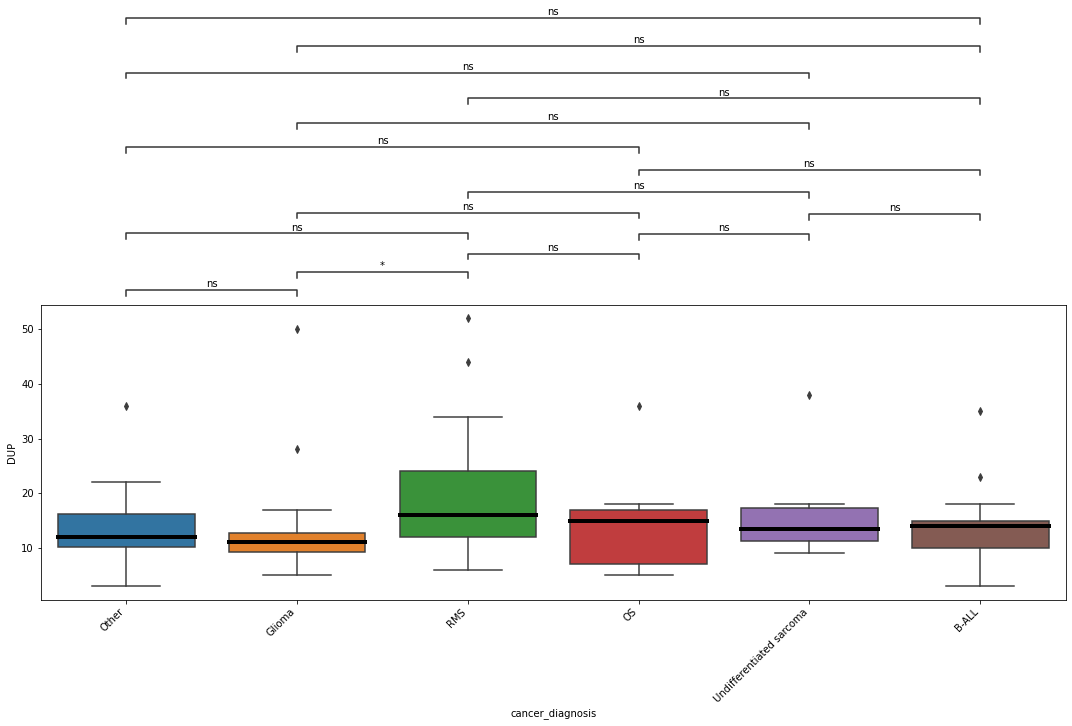

In [180]:
graphBoxGen('cancer_diagnosis', kD.drop(['DEL', 'INV'], axis=1).reset_index(),'DUP')

SV type   sample_id cancer_diagnosis   DUP
0              1087               AA   8.0
1              1092              MFH   8.0
2              1355              RMS   9.0
3              1357       Unaffected   7.0
4              1476              CPC  10.0
..              ...              ...   ...
60       SJACT001_G              ACC  13.0
61       SJACT002_G              ACC  11.0
62       SJACT005_G              ACC  40.0
63       SJACT007_G              ACC  11.0
64       SJACT008_G              ACC  17.0

[65 rows x 3 columns]
SV type sample_id cancer_diagnosis   DUP
47           4227              RMS  12.0
49           4329              RMS  14.0
the outliers for RMS are:
['4227', '4329']

Empty DataFrame
Columns: [sample_id, cancer_diagnosis, DUP]
Index: []
the outliers for Unaffected are:
[]

SV type   sample_id cancer_diagnosis   DUP
20             2957              ACC  22.0
31             3425              ACC  21.0
62       SJACT005_G              ACC  40.0
the outliers fo

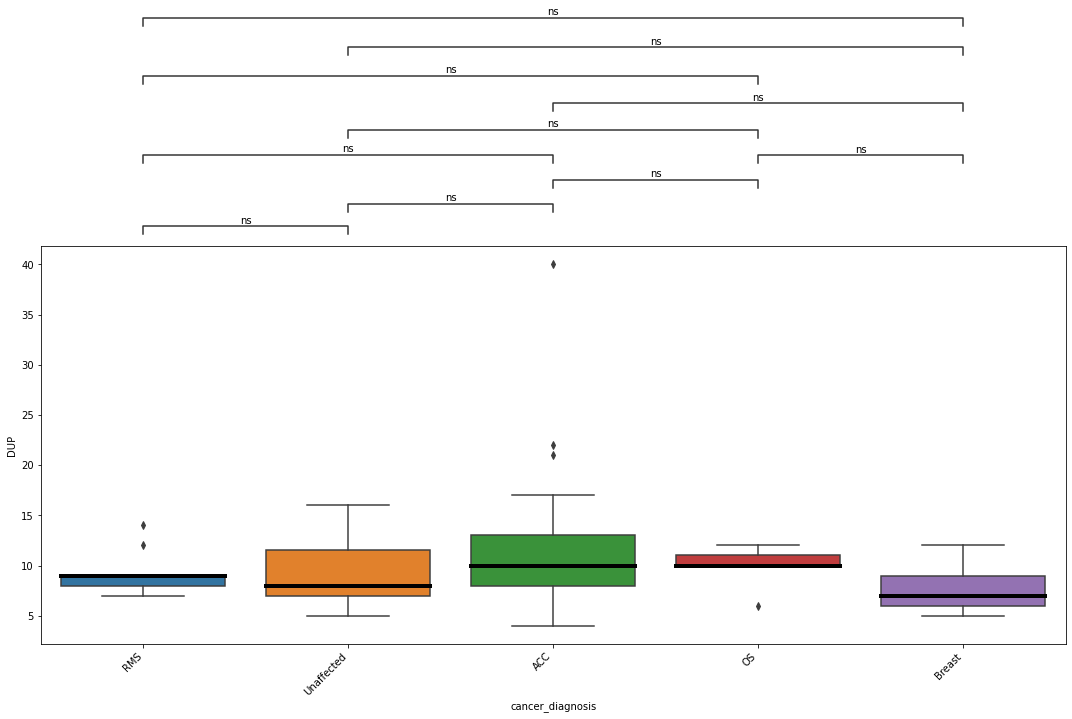

In [181]:
graphBoxGen('cancer_diagnosis', lD.drop(['DEL', 'INV'], axis=1).reset_index(),'DUP')

SV type    sample_id cancer_diagnosis  INV
0            18_1508            Other   13
1            18_1605            T-NHL    4
2            18_2028           Glioma    5
3            18_4155           Glioma    4
4            18_4156              RMS    5
..               ...              ...  ...
88              5547               OS    7
89       N_-_18_2697           Breast    5
90       N_-_18_5639              RMS    5
91        N_-_318953            B-ALL    6
92        N_-_333809              RMS    1

[93 rows x 3 columns]
Empty DataFrame
Columns: [sample_id, cancer_diagnosis, INV]
Index: []
the outliers for Other are:
[]

SV type sample_id cancer_diagnosis  INV
16         286909           Glioma   22
36         300683           Glioma   30
the outliers for Glioma are:
['286909', '300683']

Empty DataFrame
Columns: [sample_id, cancer_diagnosis, INV]
Index: []
the outliers for RMS are:
[]

SV type sample_id cancer_diagnosis  INV
7          271112               OS   15
the outl

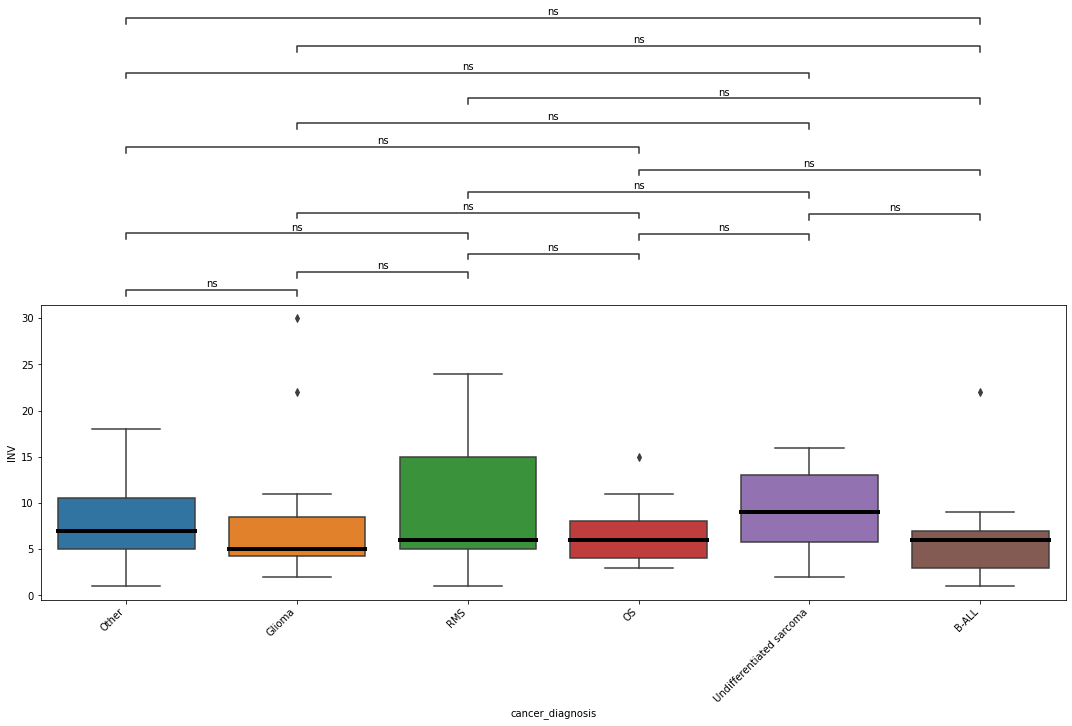

In [182]:
graphBoxGen('cancer_diagnosis', kD.drop(['DUP', 'DEL'], axis=1).reset_index(),'INV')

SV type   sample_id cancer_diagnosis   INV
0              1087               AA   4.0
1              1092              MFH   5.0
2              1355              RMS   3.0
3              1357       Unaffected   2.0
4              1476              CPC   5.0
..              ...              ...   ...
60       SJACT001_G              ACC   2.0
61       SJACT002_G              ACC   NaN
62       SJACT005_G              ACC  21.0
63       SJACT007_G              ACC   5.0
64       SJACT008_G              ACC   4.0

[65 rows x 3 columns]
SV type sample_id cancer_diagnosis  INV
49           4329              RMS  8.0
the outliers for RMS are:
['4329']

Empty DataFrame
Columns: [sample_id, cancer_diagnosis, INV]
Index: []
the outliers for Unaffected are:
[]

SV type   sample_id cancer_diagnosis   INV
29             3365              ACC  21.0
62       SJACT005_G              ACC  21.0
the outliers for ACC are:
['3365', 'SJACT005_G']

SV type sample_id cancer_diagnosis   INV
58       PD13489b 

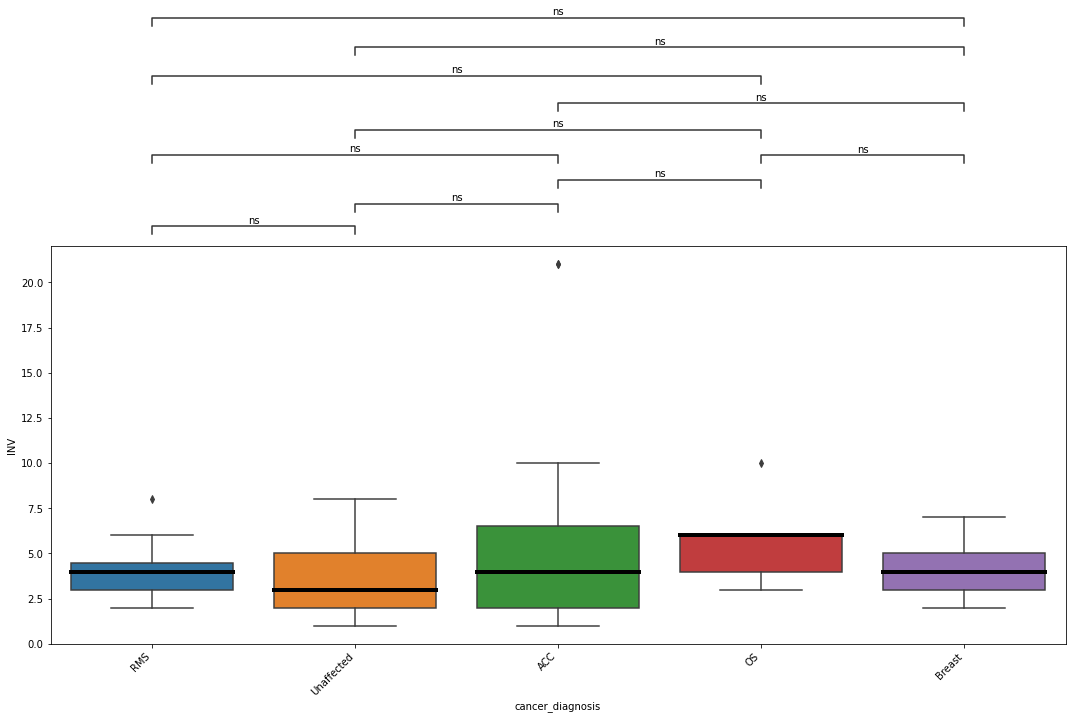

In [183]:
graphBoxGen('cancer_diagnosis', lD.drop(['DUP', 'DEL'], axis=1).reset_index(),'INV')

In [184]:
"""
LFS vs Unaffected -> done
Types of graphs:
age of onset (kics vs lfs) >SV Specific but not cancer specific
Between cancer types in kics and in lfs >done

Same for TE
"""

'\nLFS vs Unaffected -> done\nTypes of graphs:\nage of onset (kics vs lfs) >SV Specific but not cancer specific\nBetween cancer types in kics and in lfs >done\n\nSame for TE\n'

In [185]:
"SV Specific for different age of onsets"
#remove unaffected from lfs
#using diagnosis_age (days) and ageofonset || kics and lfs

lfsCancer = bigLDf[bigLDf['tissue_type']!='Unaffected'].drop(['GD_AF', 'sample', 'tissue_type',
                                                             'SV chrom', 'cancer_diagnosis'],axis=1)
lfsUnaffected = bigLDf[bigLDf['tissue_type']=='Unaffected'].drop(['GD_AF', 'sample', 'tissue_type',
                                                             'SV chrom', 'cancer_diagnosis'],axis=1)
kicsCancer = bigKDf.drop(['abbv_id', 'CCP germline', 'tumour_class','tissue_type','cancer_diagnosis'],axis=1)

LFS
   sample_id age6  freq dataset
47  PD13489b  >=6   242     lfs
the outliers for >=6 are:
['PD13489b']

   sample_id age6  freq dataset
18      3356   <6   322     lfs
21      3425   <6   225     lfs
the outliers for <6 are:
['3356', '3425']

  sample_id        age6  freq dataset
3      2447  Unaffected    62     lfs
the outliers for Unaffected are:
['2447']

KICS
   sample_id age6  freq dataset
11    273309   <6   404    kics
65    316626   <6   447    kics
66    316747   <6   367    kics
the outliers for <6 are:
['273309', '316626', '316747']

   sample_id age6  freq dataset
5    18_5256  >=6   292    kics
7     271112  >=6   417    kics
9     271116  >=6   369    kics
14    284386  >=6   532    kics
16    286909  >=6   484    kics
28    297377  >=6   298    kics
36    300683  >=6   472    kics
79    326693  >=6   298    kics
the outliers for >=6 are:
['18_5256', '271112', '271116', '284386', '286909', '297377', '300683', '326693']

p-value annotation legend:
      ns: p <= 1.00e

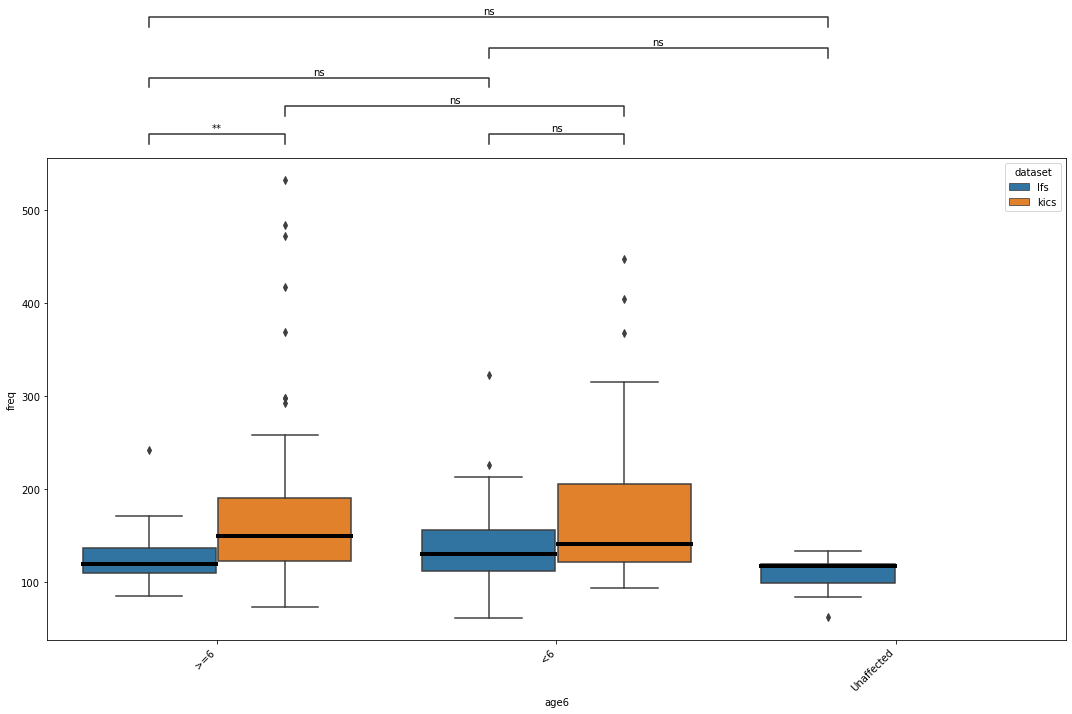

LFS
   sample_id age6  freq dataset
10     2760A  >=6   161     lfs
47  PD13489b  >=6   221     lfs
the outliers for >=6 are:
['2760A', 'PD13489b']

   sample_id age6  freq dataset
18      3356   <6   276     lfs
21      3425   <6   195     lfs
the outliers for <6 are:
['3356', '3425']

Empty DataFrame
Columns: [sample_id, age6, freq, dataset]
Index: []
the outliers for Unaffected are:
[]

KICS
   sample_id age6  freq dataset
11    273309   <6   350    kics
65    316626   <6   393    kics
66    316747   <6   302    kics
the outliers for <6 are:
['273309', '316626', '316747']

   sample_id age6  freq dataset
7     271112  >=6   366    kics
9     271116  >=6   318    kics
14    284386  >=6   456    kics
16    286909  >=6   434    kics
28    297377  >=6   266    kics
36    300683  >=6   392    kics
the outliers for >=6 are:
['271112', '271116', '284386', '286909', '297377', '300683']

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 

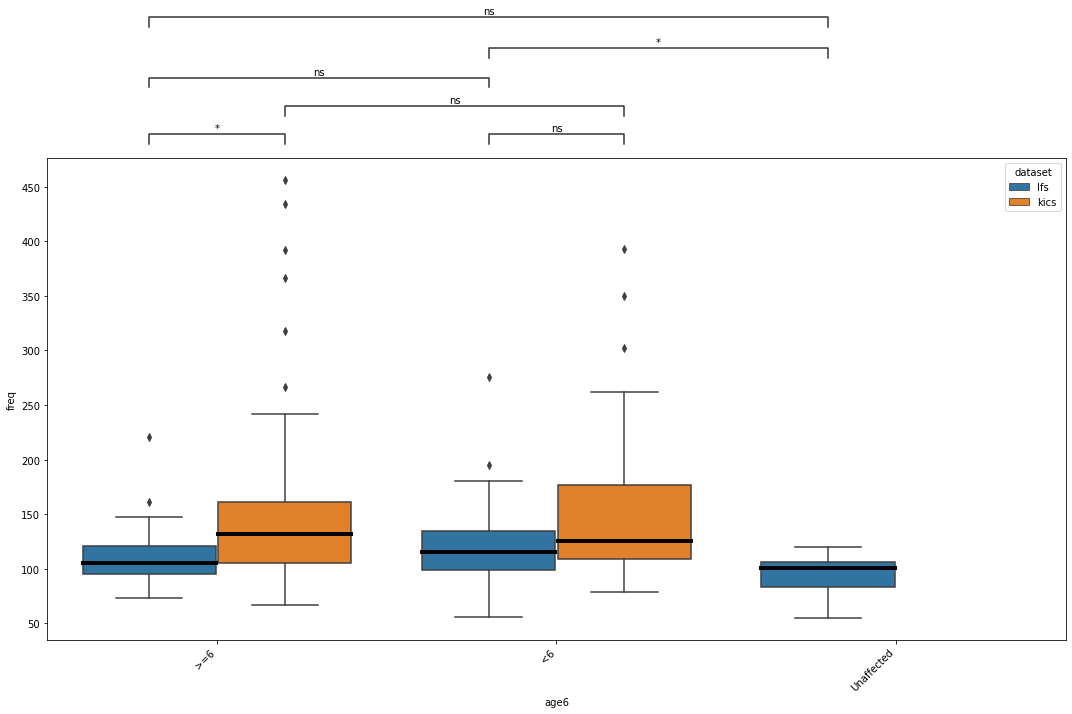

In [186]:
def ageOfOnsetKics(row):
    if row['ageofonset']<2190:
        return '<6'
    if row['ageofonset']>=2190:
        return '>=6'
    
def ageOfOnsetLfs(row):
    if row['ageofonset']<72:
        return '<6'
    if row['ageofonset']>=72:
        return '>=6'    

kicsCancer['ageofonset']=kicsCancer['ageofonset'].astype('float')
#print(lfsCancer.apply(lambda row: ageOfOnsetLfs(row), axis=1).value_counts())
#print(kicsCancer.apply(lambda row: ageOfOnsetKics(row), axis=1).value_counts())

lfsCancer['age6'] = lfsCancer.apply(lambda row: ageOfOnsetLfs(row), axis=1)
kicsCancer['age6'] = kicsCancer.apply(lambda row: ageOfOnsetKics(row), axis=1)
lfsUnaffected['age6'] = 'Unaffected'

LCDel = lfsCancer.loc[lfsCancer['SV type'] == 'DEL']
LUDel = lfsUnaffected.loc[lfsUnaffected['SV type'] == 'DEL']
KCDel = kicsCancer.loc[kicsCancer['SV type'] == 'DEL']

LCDup = lfsCancer.loc[lfsCancer['SV type'] == 'DUP']
LUDup = lfsUnaffected.loc[lfsUnaffected['SV type'] == 'DUP']
KCDup = kicsCancer.loc[kicsCancer['SV type'] == 'DUP']

LCInv = lfsCancer.loc[lfsCancer['SV type'] == 'INV']
LUInv = lfsUnaffected.loc[lfsUnaffected['SV type'] == 'INV']
KCInv = kicsCancer.loc[kicsCancer['SV type'] == 'INV']

#graph them now (2190 is 365*6)

#print(LCInv.columns)

def cleaning(df):
    df = df.drop(['SV type','ageofonset'],axis=1)
    df = df.groupby(['sample_id']).value_counts()
    df = df.to_frame().reset_index()
    df.rename(columns = {0: 'freq'},inplace = True)
    return df

def mergeDFs(lfs1, lfs2, kics1):
    lfs1 = cleaning(lfs1)
    lfs2 = cleaning(lfs2)
    kics1 = cleaning(kics1)
    lfsMerged = pd.concat([lfs1,lfs2])
    lfsMerged['dataset'] = 'lfs'
    kics1['dataset'] = 'kics'
    mergedDf = pd.concat([lfsMerged, kics1])
    
    BoxGraphMulti(mergedDf, 'age6', 'freq', 'dataset', ['<6','>=6','Unaffected'])

mergeDFs(lfsCancer, lfsUnaffected, kicsCancer)
    
mergeDFs(LCDel, LUDel, KCDel)

LFS
Empty DataFrame
Columns: [sample_id, age6, freq, dataset]
Index: []
the outliers for >=6 are:
[]

     sample_id age6  freq dataset
13        2957   <6    22     lfs
18        3356   <6    30     lfs
21        3425   <6    21     lfs
51  SJACT005_G   <6    40     lfs
the outliers for <6 are:
['2957', '3356', '3425', 'SJACT005_G']

Empty DataFrame
Columns: [sample_id, age6, freq, dataset]
Index: []
the outliers for Unaffected are:
[]

KICS
   sample_id age6  freq dataset
11    273309   <6    38    kics
59    315488   <6    34    kics
65    316626   <6    36    kics
66    316747   <6    38    kics
72    319104   <6    35    kics
the outliers for <6 are:
['273309', '315488', '316626', '316747', '319104']

   sample_id age6  freq dataset
5    18_5256  >=6    36    kics
7     271112  >=6    36    kics
9     271116  >=6    33    kics
14    284386  >=6    52    kics
36    300683  >=6    50    kics
79    326693  >=6    44    kics
the outliers for >=6 are:
['18_5256', '271112', '271116', '2

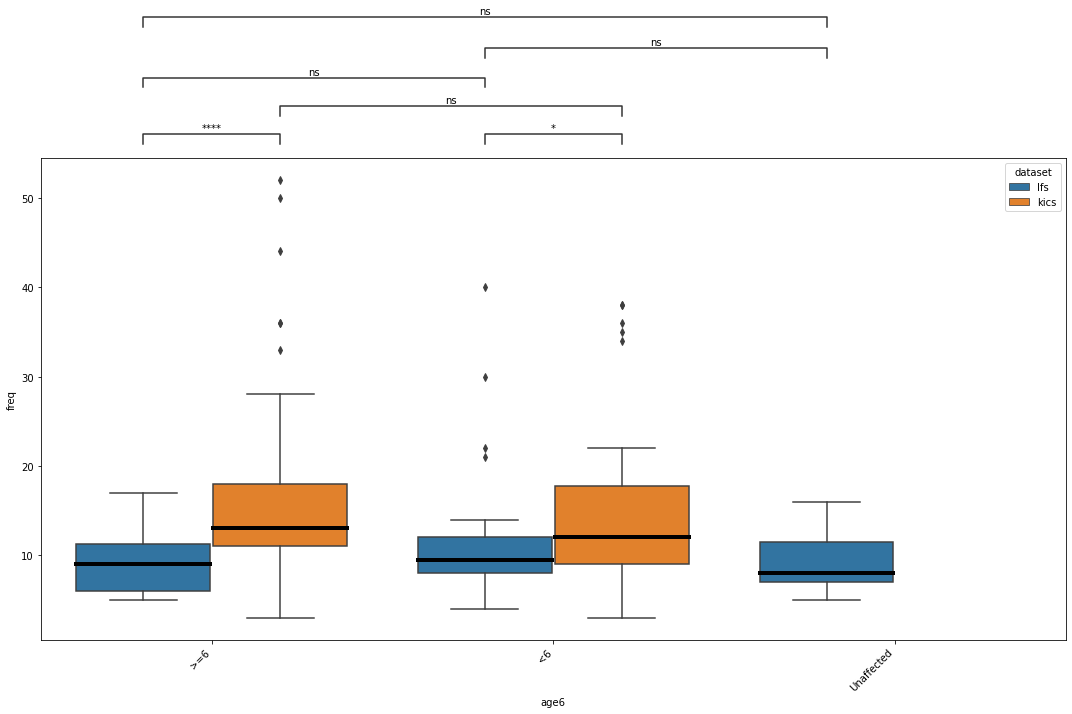

In [187]:
mergeDFs(LCDup, LUDup, KCDup)

LFS
   sample_id age6  freq dataset
46  PD13489b  >=6    10     lfs
the outliers for >=6 are:
['PD13489b']

     sample_id age6  freq dataset
19        3365   <6    21     lfs
49  SJACT005_G   <6    21     lfs
the outliers for <6 are:
['3365', 'SJACT005_G']

Empty DataFrame
Columns: [sample_id, age6, freq, dataset]
Index: []
the outliers for Unaffected are:
[]

KICS
   sample_id age6  freq dataset
66    316747   <6    27    kics
72    319104   <6    22    kics
the outliers for <6 are:
['316747', '319104']

   sample_id age6  freq dataset
14    284386  >=6    24    kics
16    286909  >=6    22    kics
36    300683  >=6    30    kics
the outliers for >=6 are:
['284386', '286909', '300683']

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

<6_lfs vs. <6_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:4.551e-02 U_stat=3.780e+02
>=6_lfs vs. >=6_kics: Mann-Whi

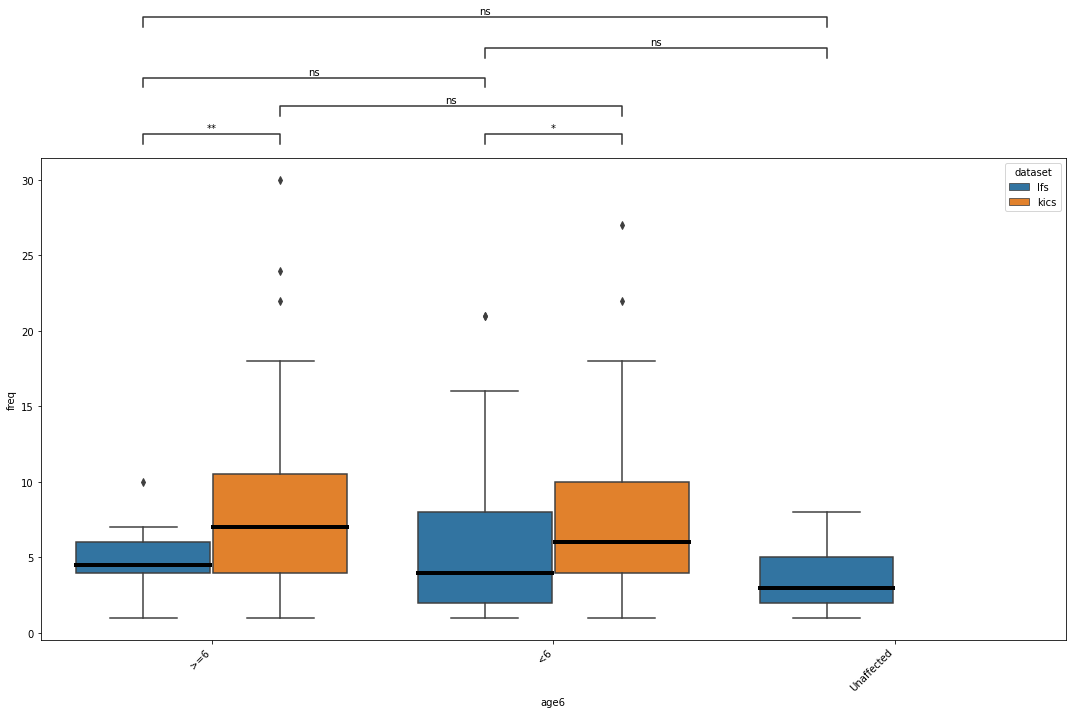

In [188]:
mergeDFs(LCInv, LUInv, KCInv)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MFH vs. RMS: Mann-Whitney-Wilcoxon test two-sided, P_val:8.000e-01 U_stat=3.000e+00
RMS vs. High Grade Sarcoma: Mann-Whitney-Wilcoxon test two-sided, P_val:8.000e-01 U_stat=6.000e+00
High Grade Sarcoma vs. LMS: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=1.000e+00
LMS vs. MFS: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=0.000e+00
MFH vs. High Grade Sarcoma: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=1.000e+00
RMS vs. LMS: Mann-Whitney-Wilcoxon test two-sided, P_val:4.000e-01 U_stat=8.000e+00
High Grade Sarcoma vs. MFS: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=1.000e+00
MFH vs. LMS: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=1.000e+00
RMS vs. MFS: Mann-Whitney-Wilcoxon test two-sided, P_val:4.000e-01 U_stat=8.000e+00
MFH

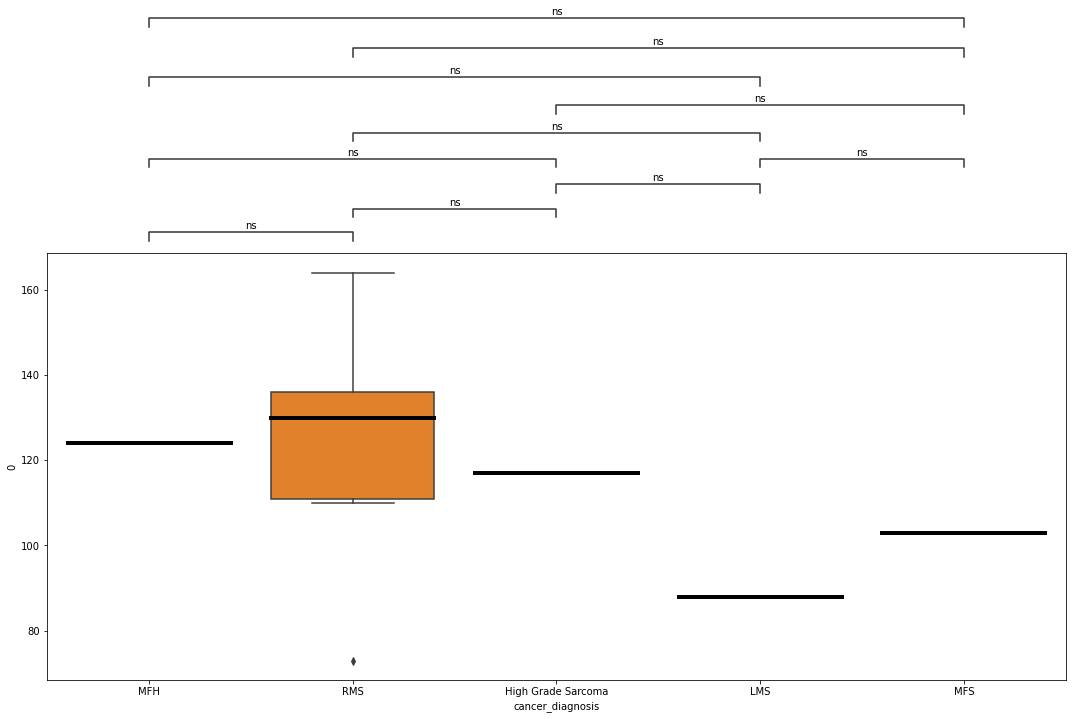

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

ARMS_kics vs. ARMS_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:3.333e-01 U_stat=5.000e+00
ERMS_kics vs. ERMS_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:8.125e-02 U_stat=3.800e+01
ERMS_lfs vs. ARMS_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:1.255e-01 U_stat=6.000e+00
ERMS_kics vs. ARMS_kics: Mann-Whitney-Wilcoxon test two-sided, P_val:7.242e-01 U_stat=1.700e+01
ERMS_kics vs. ARMS_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:8.889e-01 U_stat=5.000e+00


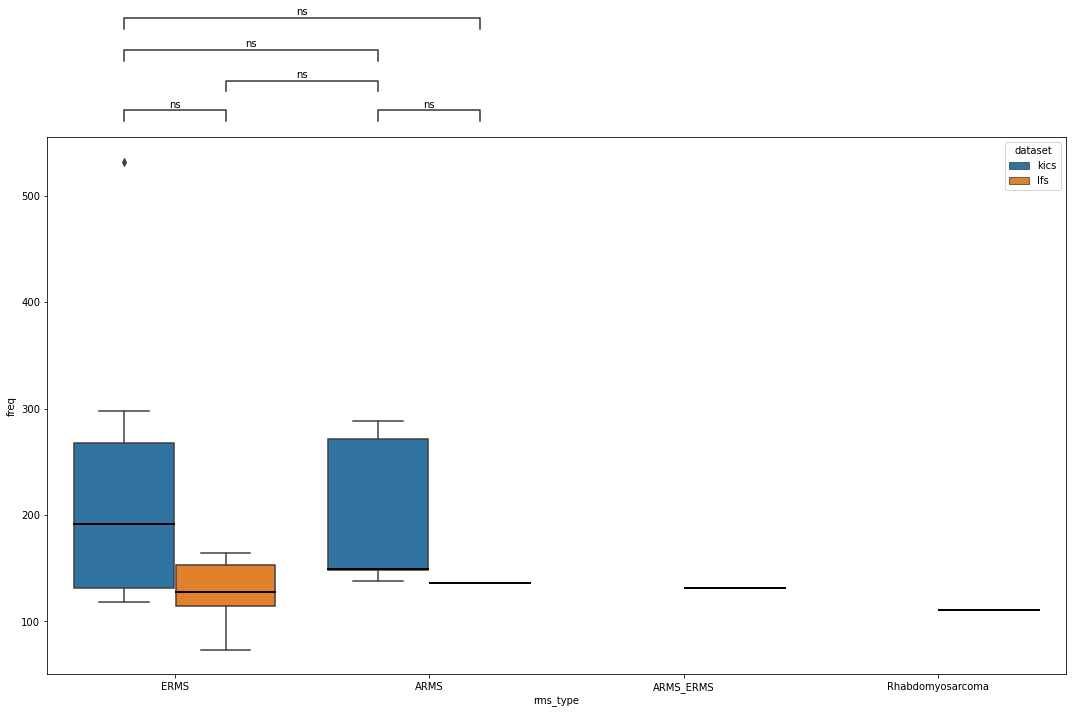

In [189]:
"""
Those in RMS are they A RMS or E RMS (cancer diagnosis)
Those in Soft Tissue, What group are they? (tissue_type)
"""
rmsKDf = UberbigKDf[['sample_id','ICDO-diagnosis','tissue_type','lfs_cancer_type_diagnosis']]
rmsLDf = UberbigLDf[['sample_id','cancer1','tissue_type','cancer_diagnosis']]

#stKDf = rmsKDf.loc[rmsKDf['tissue_type']=='Soft Tissue']
rmsKDf = rmsKDf.loc[rmsKDf['lfs_cancer_type_diagnosis']=='RMS']

#they are the same for kics
#print(rmsKDf['sample_id'].unique())
#print(stKDf['sample_id'].unique())

rmsKDf = rmsKDf.drop(['tissue_type','lfs_cancer_type_diagnosis'], axis=1).groupby(['sample_id']).value_counts().to_frame().reset_index()
rmsKDf['dataset']='kics'

#these are not the same for lfs
stLDf = rmsLDf.loc[rmsLDf['tissue_type']=='Soft Tissue']
stLDf = stLDf.drop(['tissue_type'],axis=1).groupby(['sample_id','cancer_diagnosis']).value_counts().to_frame().reset_index()

ax = sns.boxplot(data=stLDf, x='cancer_diagnosis', y=0, medianprops={"linewidth": 4, 'color':'black'})
    
uniqueList = list(stLDf['cancer_diagnosis'].unique())
listPairing = [(a,b) for x, a in enumerate(uniqueList) for b in uniqueList[x+1:]]
        
annot = Annotator(ax, listPairing, data=stLDf, x='cancer_diagnosis', y=0)
annot.configure(test='Mann-Whitney',
                    text_format='star', loc='outside', verbose=2)
annot.apply_and_annotate()
plt.show()

rmsLDf = rmsLDf.loc[rmsLDf['cancer_diagnosis']=='RMS']
rmsLDf = rmsLDf.drop(['tissue_type','cancer_diagnosis'], axis=1).groupby(['sample_id']).value_counts().to_frame().reset_index()
rmsLDf['dataset']='lfs'


#formatting kics
def rmsType(row):
    if ('lveolar' in row['type']) and ('habdomyosarcoma' in row['type']):
        return 'ARMS'
    if ('mbryonal' in row['type']) and ('habdomyosarcoma' in row['type']):
        return 'ERMS'
    if('ERMS' in row['type']) and ('ARMS' not in row['type']):
        return 'ERMS'
    return row['type']


rmsLDf = rmsLDf.rename(columns={'cancer1': 'type',0:'freq'})
rmsKDf = rmsKDf.rename(columns={'ICDO-diagnosis':'type', 0:'freq'})

#print(rmsLDf.apply(lambda row: rmsType(row), axis=1).value_counts())
#print(rmsKDf.apply(lambda row: rmsType(row), axis=1).value_counts())

rmsLDf['rms_type'] = rmsLDf.apply(lambda row: rmsType(row), axis=1)
rmsKDf['rms_type'] = rmsKDf.apply(lambda row: rmsType(row), axis=1)

mergedRMS = pd.concat([rmsKDf,rmsLDf])

bx = sns.boxplot(data=mergedRMS, x='rms_type', y='freq',hue = 'dataset', medianprops={"linewidth": 2, 'color':'black'})

listPairing = [(('ERMS','kics'),('ERMS','lfs')), (('ERMS','kics'),('ARMS','lfs')),
               (('ARMS','kics'),('ERMS','lfs')), (('ARMS','kics'),('ARMS','lfs')),
               (('ARMS','kics'),('ERMS','kics'))]

annot = Annotator(bx, listPairing, data=mergedRMS, x='rms_type', y='freq',hue = 'dataset')
annot.configure(test='Mann-Whitney',
                    text_format='star', loc='outside', verbose=2)
annot.apply_and_annotate()
plt.show()

In [193]:
"""
Search for and print the entire row given sample_id
"""
kid = '271112'
#print(UberbigKDf.loc[UberbigKDf['sample_id']== kid])

lid = 'PD13489b'
print(UberbigLDf.loc[UberbigLDf['sample_id']== lid])

     sample_id SV chrom     GD_AF SV type    sample   meth_id  p53  tm_donor  \
4083  PD13489b        1 -1.000000     DEL  PD13489b  PD13489b  Mut  PD13489b   
4084  PD13489b        1  0.000047     DEL  PD13489b  PD13489b  Mut  PD13489b   
4085  PD13489b        1  0.009751     DEL  PD13489b  PD13489b  Mut  PD13489b   
4086  PD13489b        1 -1.000000     DEL  PD13489b  PD13489b  Mut  PD13489b   
4087  PD13489b        1  0.002701     DEL  PD13489b  PD13489b  Mut  PD13489b   
...        ...      ...       ...     ...       ...       ...  ...       ...   
4320  PD13489b        X -1.000000     DEL  PD13489b  PD13489b  Mut  PD13489b   
4321  PD13489b        X  0.000047     DUP  PD13489b  PD13489b  Mut  PD13489b   
4322  PD13489b        X  0.000047     DEL  PD13489b  PD13489b  Mut  PD13489b   
4323  PD13489b        X  0.000141     DEL  PD13489b  PD13489b  Mut  PD13489b   
4324  PD13489b        X  0.000047     DEL  PD13489b  PD13489b  Mut  PD13489b   

     tissue_type cancer_diagnosis  ... 